In [ ]:
from matplotlib.dates import date2num
from collections import namedtuple
from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from typing import Tuple, Sequence
from numbers import Real as N

In [ ]:
#1.Gross Range Test
SUSPECT_SPAN = [3, 150]
FAIL_SPAN = [0, 180]

SUSPECT_SPAN_DIR = [0, 359]
FAIL_SPAN_DIR = [0, 359]

#2.Spike Test
SUSPECT_THRESHOLD = 20
FAIL_THRESHOLD = 50

#3.Rate of Change Test
THRESHOLD = 0.1

#4.Flat Line Test
TOLERANCE = 2, 
FAIL_THRESHOLD_FLAT = 5
SUSPECT_THRESHOLD_FLAT = 3



GOOD = 1
UNKNOWN = 2
SUSPECT = 3
FAIL = 4
MISSING = 9

In [ ]:
default_qc = list("112222222")
default_qc_direction = list("112222222")
qc_overall =[]
qc_overall_direction = []

span = namedtuple('Span', 'low high')

drive.mount('/content/gdrive')
col_list = ["sensorId", "observationDate","instrument","verticalDatum","direction","speed","verticalVelocity","echoIntensityB1","echoIntensityB2","echoIntensityB3","echoIntensityB4","binNumber","Veast","Vnorth"]
dfInit = pd.read_csv("/content/gdrive/My Drive/rs/currents_testfile2.csv", usecols=col_list)

print(dfInit)
current_list = dfInit["speed"].values.tolist()
direction_list = dfInit["direction"].values.tolist()

Mounted at /content/gdrive
       sensorId       observationDate  instrument  ...  binNumber   Veast  Vnorth
0          3028  2021-06-30T00:06:00Z           0  ...          1    -2.7     6.0
1          3028  2021-06-30T00:06:00Z           0  ...          2     2.7    -1.3
2          3028  2021-06-30T00:06:00Z           0  ...          3    -0.5     3.4
3          3028  2021-06-30T00:06:00Z           0  ...          4     1.1     4.9
4          3028  2021-06-30T00:06:00Z           0  ...          5     3.2     5.0
...         ...                   ...         ...  ...        ...     ...     ...
18715      3028  2021-07-01T23:56:00Z           0  ...         61    18.0    50.6
18716      3028  2021-07-01T23:56:00Z           0  ...         62   -17.5     4.7
18717      3028  2021-07-01T23:56:00Z           0  ...         63   -11.0    -5.9
18718      3028  2021-07-01T23:56:00Z           0  ...         64 -9999.0 -9999.0
18719      3028  2021-07-01T23:56:00Z           0  ...         65 -9999

min depth:  43.11
max depth:  1067.13
[[43.11, 46.11], [59, 62], [75, 78], [91, 94], [107, 110], [123, 126], [139, 142], [155, 158], [171, 174], [187, 190], [203, 206], [219, 222], [235, 238], [251, 254], [267, 270], [283, 286], [299, 302], [315, 318], [331, 334], [347, 350], [363, 366], [379, 382], [395, 398], [411, 414], [427, 430], [443, 446], [459, 462], [475, 478], [491, 494], [507, 510], [523, 526], [539, 542], [555, 558], [571, 574], [587, 590], [603, 606], [619, 622], [635, 638], [651, 654], [667, 670], [683, 686], [699, 702], [715, 718], [731, 734], [747, 750], [763, 766], [779, 782], [795, 798], [811, 814], [827, 830], [843, 846], [859, 862], [875, 878], [891, 894], [907, 910], [923, 926], [939, 942], [955, 958], [971, 974], [987, 990], [1003, 1006], [1019, 1022], [1035, 1038], [1051, 1054], [1067, 1070]]


Stick-plot - original/without qc
Depth: 43.11 to 46.11 m


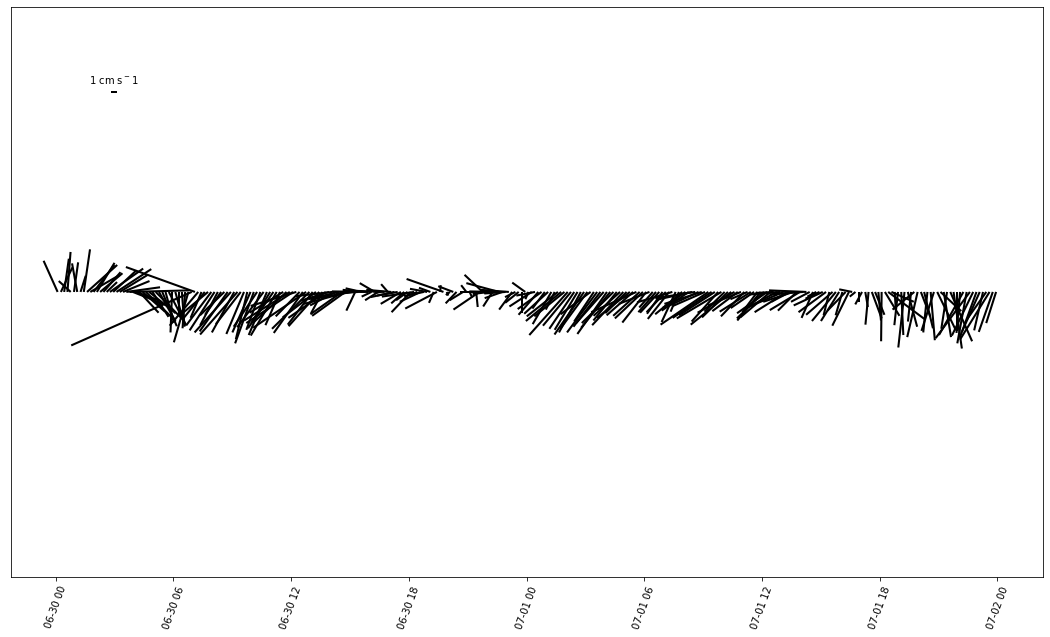





Stick-plot - original/without qc
Depth: 555 to 558 m


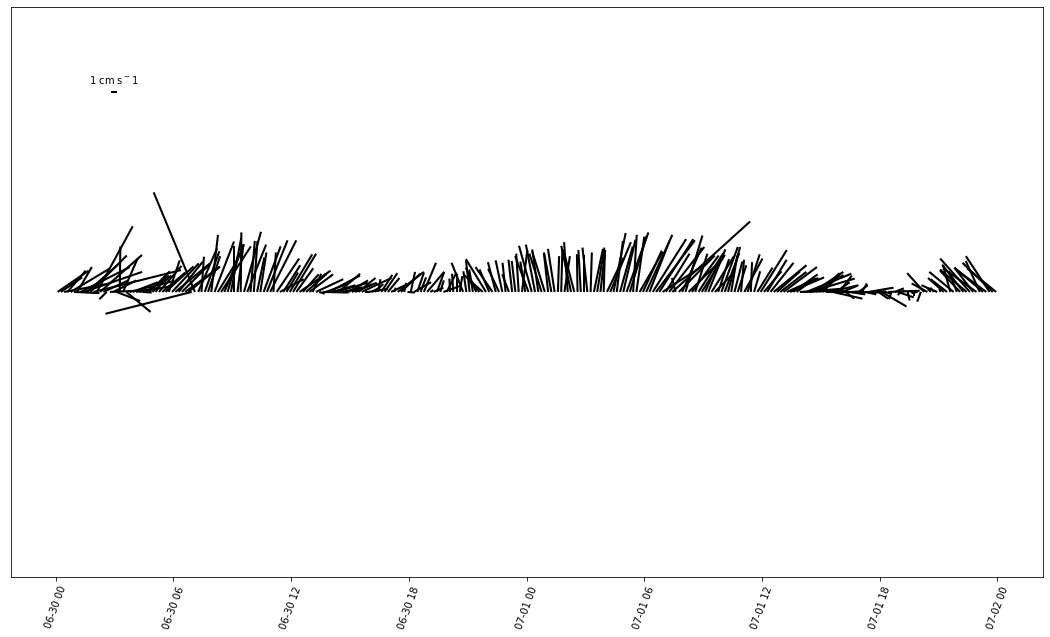





Stick-plot - original/without qc
Depth: 1051 to 1054 m


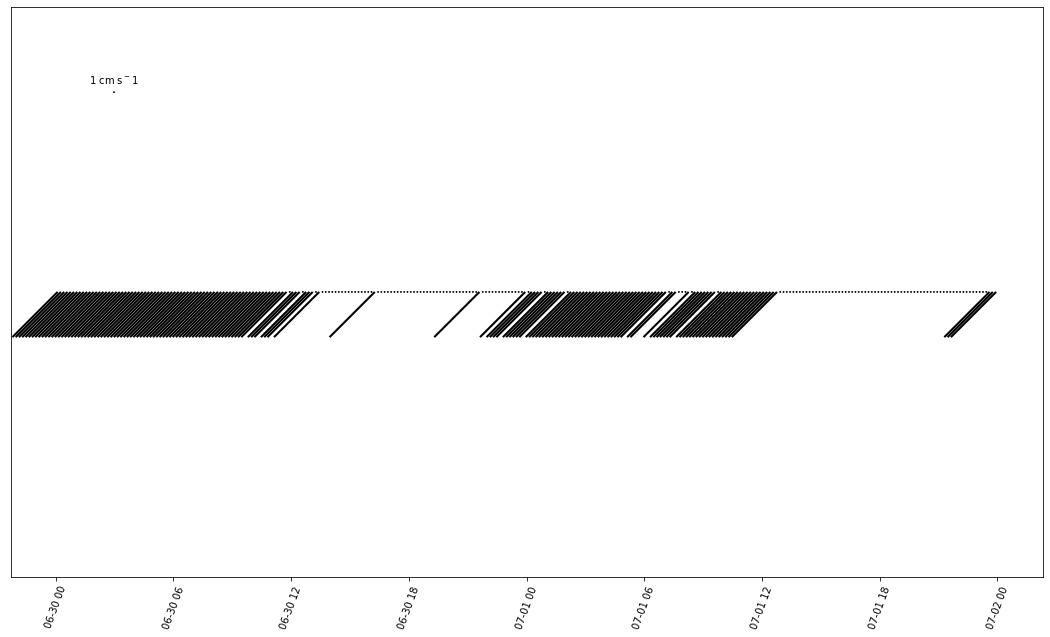

In [ ]:
def stick_plot(dates, u, v, d, **kw):
    hl = kw.pop('hl', 0)
    hw = kw.pop('hw', 0)
    hal = kw.pop('hal', 0)
    w = kw.pop('w', 0.002)
    
    angles = kw.pop('angles', 'uv')
    ax = kw.pop('ax', None)
    
    if (d is not None):
      l=list(d)
      a = np.array([])
      for i in l:
        for k in i:
          if k=='9'or k=='3' or k=='4':
            a = np.append(a, 'r')
            break
        else:
          a = np.append(a, 'black')
    else:
      a = np.array(['black']*len(dates))
        
    if angles != 'uv':
        raise AssertionError("Stickplot angles must be 'uv'")

    dates, u, v = map(np.asanyarray, (dates, u, v))

    if not ax:
        fig, ax = plt.subplots()
    
    q = ax.quiver(date2num(dates), [[0]*len(dates)], u, v, angles='uv', width=w, headwidth=hw, 
                  headlength=hl, headaxislength=hal, **kw, color=a)

    ax.axes.get_yaxis().set_visible(False)
    ax.xaxis_date()
    return q

df = dfInit.rename(columns={'observationDate': 'time','verticalDatum': 'depth','Veast': 'u','Vnorth': 'v'})
df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S")

mind = df['depth'].min()
maxd = df['depth'].max()
print('min depth: ',mind)
print('max depth: ',maxd)

depthRanges = []
temp =-1
k =0
df = df.sort_values('depth')

for i in df['depth'].unique():
  if temp==-1:
    temp = i
    depthRanges.append([i,i+3])
  else:
    result= i-temp
    temp = i
    if result>3:
        k=k+1
        depthRanges.append([int(temp), int(temp+3)])

print(depthRanges)

temp = df[df['speed'] != -9999.0]['depth']
last_dep = temp.to_list()[-1]
last_dep_index =''

for index, z in enumerate(depthRanges):
  if last_dep>=z[0] and last_dep<=z[1]:
    last_dep_index = index

for k in depthRanges:
  if(k==depthRanges[0] or k==depthRanges[len(depthRanges)//2] or k==depthRanges[last_dep_index]):
    dft = df[df['depth'].between(k[0], k[1])]
    # print('Depth:', k)
    q = stick_plot([t.to_pydatetime() for t in dft["time"]], dft["u"], dft["v"], None)

    ref = 1
    qk = plt.quiverkey(
        q, 0.1, 0.85, ref, f"{ref} cm s$^{-1}$", labelpos="N", coordinates="axes"
    )

    plt.xticks(rotation=70)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5, forward=True)
    print('\n')
    print('Stick-plot - original/without qc')
    print('Depth: {} to {} m'.format(k[0],k[1]))
    plt.show()
    print('\n')

In [ ]:
#1.Gross Range Test - QC
def gross_range_test(dataInput, fail_span, suspect_span):

    if len(fail_span) != 2:
      raise ValueError('Expected length for fail_span is 2, Got: {}'.format(len(fail_span)))
    if len(suspect_span) != 2:
      raise ValueError('Expected length for suspect_span is 2, Got: {}'.format(len(suspect_span)))

    l = np.ma.masked_invalid(np.array(current_list).astype(np.float64))
    l=l.tolist()
    flag = []

    for index, i in enumerate(l):
      if i is None:
        flag.insert(index,MISSING)
      else:
        if i>=suspect_span[0] and i<=suspect_span[1]:
          flag.insert(index,GOOD)
        elif i>=fail_span[0] and i<=fail_span[1]:
          flag.insert(index,SUSPECT)
        else:
          flag.insert(index,FAIL)

    return flag

default_qc = list("112222222")
default_qc_direction = list("112222222")
print("1.Gross Range Test")
results = gross_range_test(
    dataInput=current_list,
    suspect_span=[3, 150],
    fail_span=[0, 180]
)

results_direction = gross_range_test(dataInput=direction_list,
                   suspect_span=[0, 359],
                   fail_span=[0, 359])

print("direction results: ",results_direction)

qc_overall = results
qc_overall_direction = results_direction

#speed
for i in range(0, len(qc_overall)):
  #gross range qc is in 4th position
  default_qc[3]=str(qc_overall[i])
  #converting list to string
  qc_overall[i] = "".join(default_qc)

result_qc4 = qc_overall
qc_all = list(result_qc4)
for i in range(0, len(qc_all)):
  default_qc[3]=str(qc_all[i][3])
  #converting list to string
  qc_all[i] = "".join(default_qc)

qc_overall = qc_all
dfInit['qcResult'] = qc_overall
print('QC Result: ', results)

#direction
for i in range(0, len(qc_overall_direction)):
  #gross range qc is in 4th position
  default_qc_direction[3]=str(qc_overall_direction[i])
  #converting list to string
  qc_overall_direction[i] = "".join(default_qc_direction)

result_direction_qc4 = qc_overall_direction
qc_direction_all = list(result_direction_qc4)
for i in range(0, len(qc_direction_all)):
  default_qc_direction[3]=str(qc_direction_all[i][3])
  #converting list to string
  qc_direction_all[i] = "".join(default_qc_direction)

qc_overall_direction = qc_direction_all
dfInit['qcResult2'] = qc_overall_direction
print('QC Result direction: ', results_direction)

df = dfInit.rename(columns={'observationDate': 'time','verticalDatum': 'depth','Veast': 'u','Vnorth': 'v'})
df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S")
df['qcSpeedGRT'] = qc_overall

mind = df['depth'].min()
maxd = df['depth'].max()
print('min depth: ',mind)
print('max depth: ',maxd)

depthRanges = []
temp =-1
k =0
df = df.sort_values('depth')

for i in df['depth'].unique():
  if temp==-1:
    temp = i
    depthRanges.append([i,i+3])
  else:
    result= i-temp
    temp = i
    if result>3:
        k=k+1
        depthRanges.append([int(temp), int(temp+3)])

print(depthRanges)
print('\n')

print('Input data with the new column "qcResult" added:')
df["qc_overall"] = df[['qcResult', 'qcResult2']].agg(','.join, axis=1)
print(df)

1.Gross Range Test
direction results:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Input data with the new column "qcResult" added for valid observations:
       sensorId                      time  ...  qcResult2  qcSpeedGRT
5330       3028 2021-06-30 13:46:00+00:00  ...  112122222   112122222
1625       3028 2021-06-30 04:16:00+00:00  ...  112122222   112122222
0          3028 2021-06-30 00:06:00+00:00  ...  112122222   112122222
8710       3028 2021-06-30 22:26:00+00:00  ...  112122222   112122222
17420      3028 2021-07-01 20:46:00+00:00  ...  112122222   112122222
...         ...                       ...  ...        ...         ...
7603       3028 2021-06-30 19:26:00+00:00  ...  112122222   112122222
15793      3028 2021-07-01 16:26:00+00:00  ...  112122222   112122222
6433       3028 2021-06-30 16:26:00+00:00  ...  112122222   112122222
7018       3028 2021-06-30 17:56:00+00:00  ...  112122222   112122222
7538       3028 2021-06-30 19:16:00+00:00  ...  112122222   112122222

[14350 rows x 17 columns]
1. Gross Range Test
d 5330     112122222
1625     112122222
0

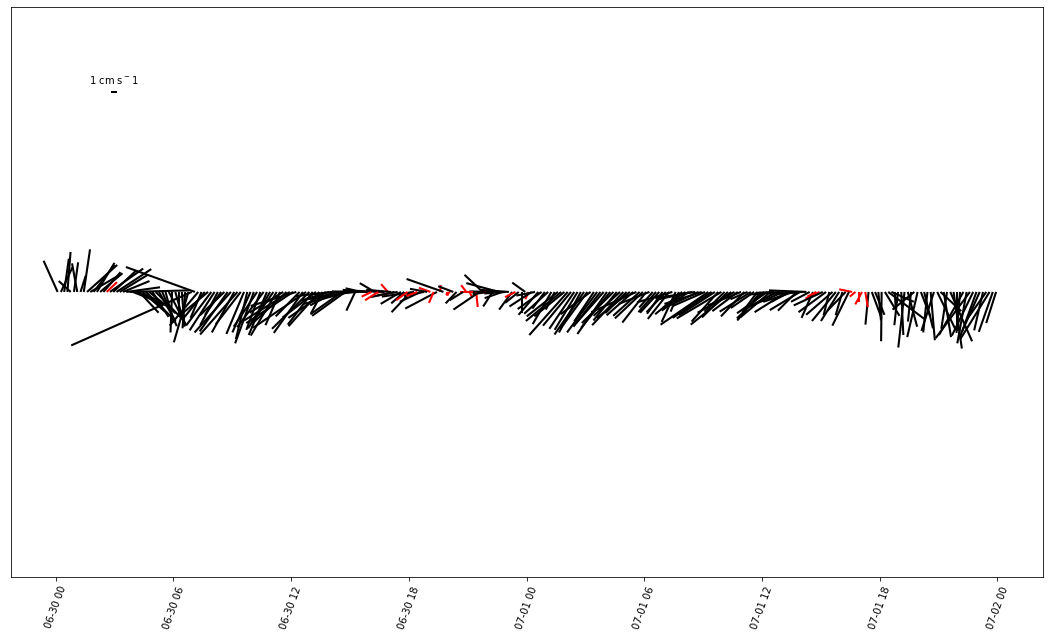



d 5330     112122222
1625     112122222
0        112122222
8710     112122222
17420    112122222
           ...    
15730    112122222
11440    112122222
12025    112122222
4290     112122222
11765    112122222
Name: qcSpeedGRT, Length: 262, dtype: object
Stick-plot with QC
Depth: 43.11 to 46.11 m


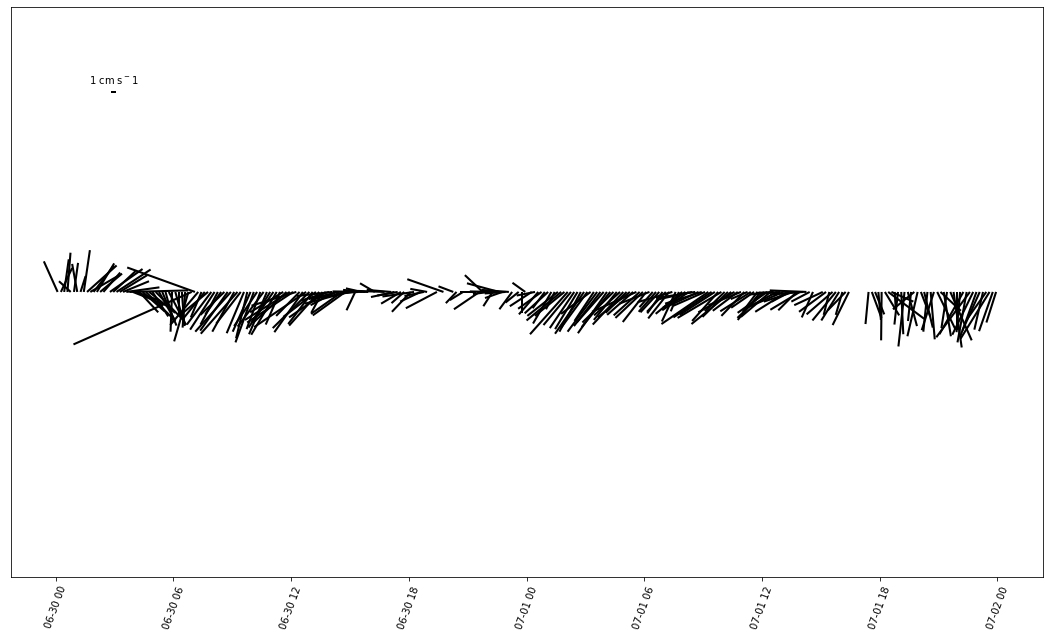



d 1657     112122222
5362     112122222
9457     112122222
13487    112122222
3217     112122222
           ...    
17647    112122222
7052     112122222
13162    112122222
7767     112122222
7507     112322222
Name: qcSpeedGRT, Length: 288, dtype: object
Stick-plot without QC
Depth: 555 to 558 m


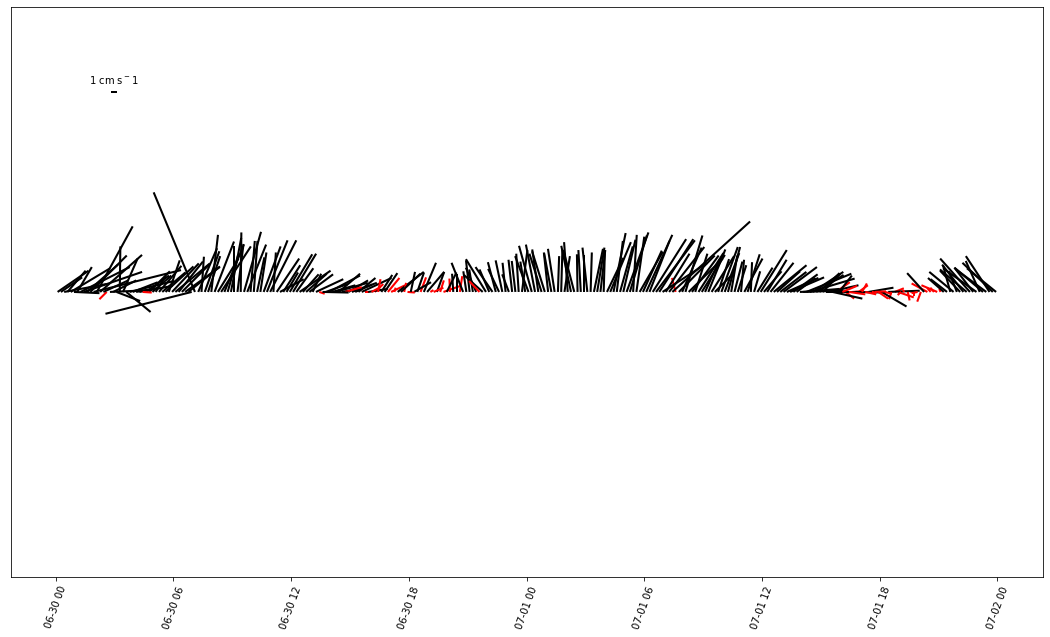



d 1657     112122222
5362     112122222
9457     112122222
13487    112122222
3217     112122222
           ...    
14592    112122222
17647    112122222
7052     112122222
13162    112122222
7767     112122222
Name: qcSpeedGRT, Length: 239, dtype: object
Stick-plot with QC
Depth: 555 to 558 m


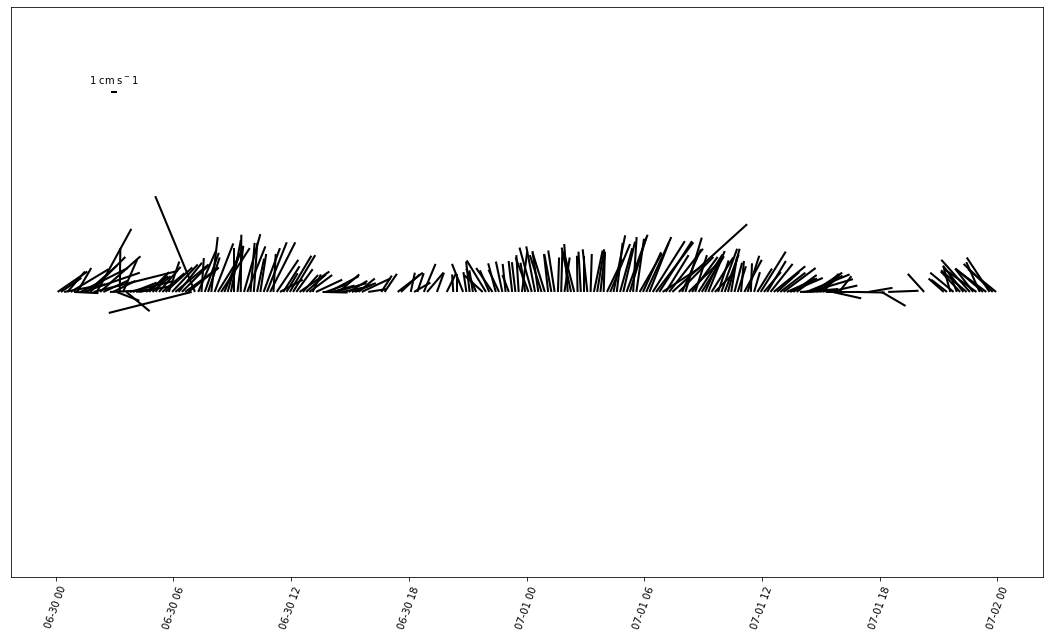



d 1688     112422222
5393     112122222
14688    112122222
3248     112422222
6628     112122222
           ...    
3963     112422222
7018     112122222
14168    112422222
7538     112122222
12738    112422222
Name: qcSpeedGRT, Length: 288, dtype: object
Stick-plot without QC
Depth: 1051 to 1054 m


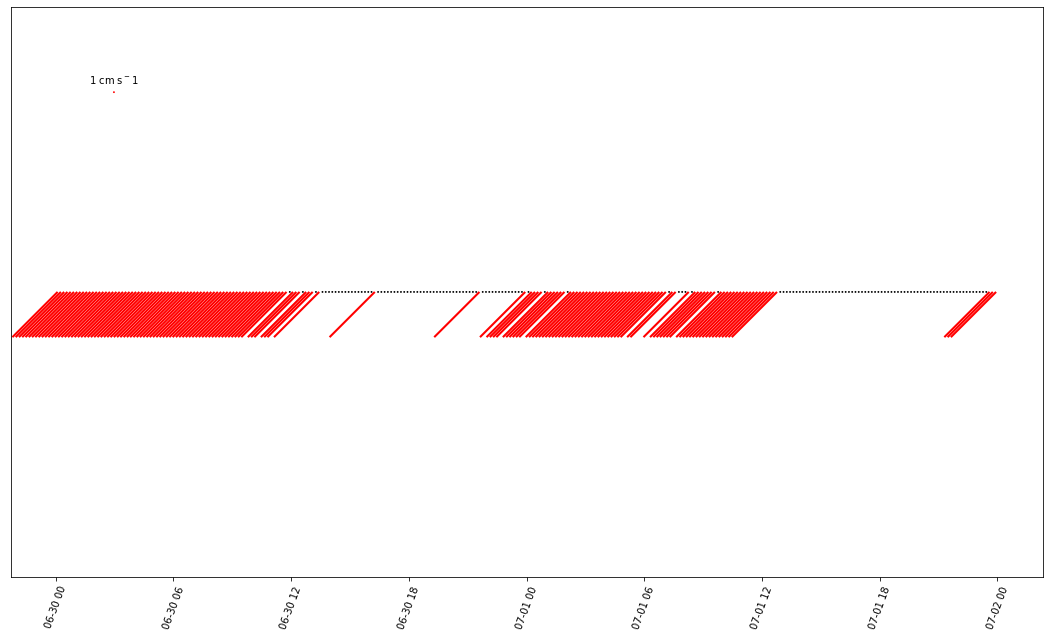



d 5393     112122222
14688    112122222
6628     112122222
5653     112122222
5718     112122222
           ...    
7603     112122222
15793    112122222
6433     112122222
7018     112122222
7538     112122222
Name: qcSpeedGRT, Length: 136, dtype: object
Stick-plot with QC
Depth: 1051 to 1054 m


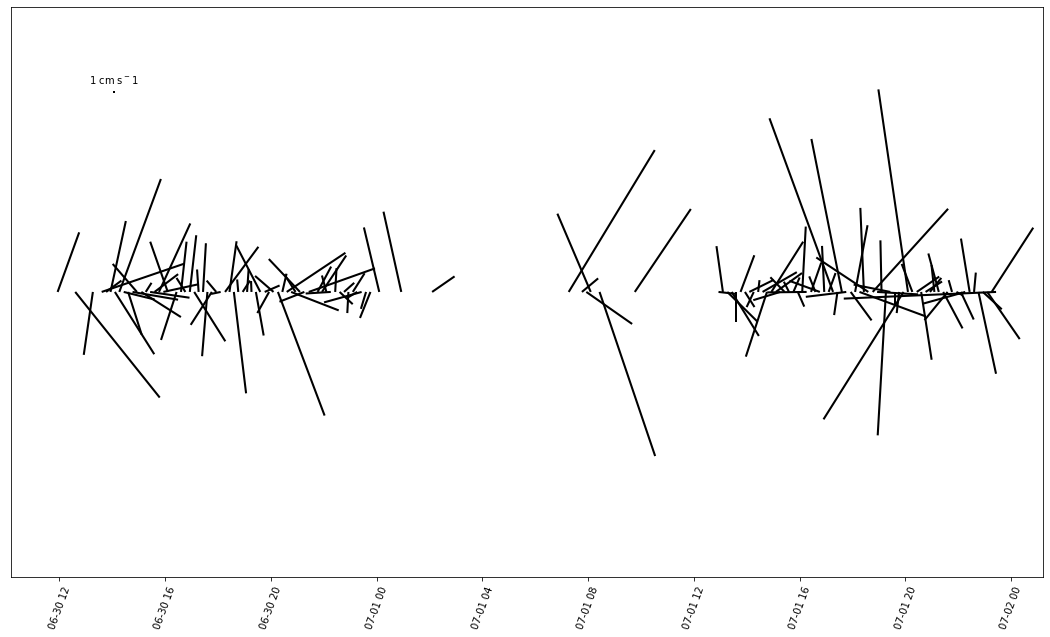

In [ ]:
#1.Gross Range Test - StickPlot
df_new = df[~df.qcSpeedGRT.str.contains('3', na=False)]
df_new = df_new[~df_new.qcSpeedGRT.str.contains('4', na=False)]
df_new = df_new[~df_new.qcSpeedGRT.str.contains('9', na=False)]
print('Input data with the new column "qcResult" added for valid observations:')
print(df_new)
print("1. Gross Range Test")

for k in depthRanges[0:len(depthRanges)]:
  if(k==depthRanges[0] or k==depthRanges[len(depthRanges)//2] or k==depthRanges[last_dep_index] ):
    dft = df[df['depth'].between(k[0], k[1])]
    # print('Depth:', k)
    q = stick_plot([t.to_pydatetime() for t in dft["time"]], dft["u"], dft["v"], dft["qcSpeedGRT"])

    ref = 1
    qk = plt.quiverkey(
        q, 0.1, 0.85, ref, f"{ref} cm s$^{-1}$", labelpos="N", coordinates="axes"
    )
    plt.xticks(rotation=70)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5, forward=True)
    print('Stick-plot without QC')
    print('Depth: {} to {} m'.format(k[0],k[1]))
    plt.plot(color='blue')
    plt.show()
    print('\n')

    dft_new = df_new[df_new['depth'].between(k[0], k[1])]

    q = stick_plot([t.to_pydatetime() for t in dft_new["time"]], dft_new["u"], dft_new["v"], dft_new["qcSpeedGRT"])

    ref = 1
    qk = plt.quiverkey(
        q, 0.1, 0.85, ref, f"{ref} cm s$^{-1}$", labelpos="N", coordinates="axes"
    )
    plt.xticks(rotation=70)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5, forward=True)
    print('Stick-plot with QC')
    print('Depth: {} to {} m'.format(k[0],k[1]))
    plt.show()
    print('\n')

In [ ]:
def spike_test(dataInput , suspect_threshold, fail_threshold):
  l = np.ma.masked_invalid(np.array(dataInput).astype(np.float64))
  l=l.tolist()
  print(l)
  flag = list()
  avgs = [2]*len(l)
  for i in range(1, len(l)-1):
    del(avgs[i])
    avgs.insert(i, (l[i-1]+l[i+1])/2)
  
  res=[]
  for i in range(0,len(l)):
    res.insert(i, abs(l[i]-avgs[i]))
    if (res[i]>suspect_threshold and res[i]<=fail_threshold):
      flag.insert(i,SUSPECT)
    elif res[i]>fail_threshold:
      flag.insert(i,FAIL)
    else:
      flag.insert(i,GOOD)
  # flag.insert(0,UNKNOWN)
  # flag.insert(len(flag)-1,UNKNOWN)
  
  return flag

default_qc = list("112222222")
default_qc_direction = list("112222222")

print("2.Spike Test")
results = spike_test(
  dataInput = current_list,
  suspect_threshold = 20,
  fail_threshold = 50
)
results_direction = spike_test(
  dataInput = direction_list,
  suspect_threshold = 20,
  fail_threshold = 50
)

qc_overall = list(results)
qc_overall_direction = list(results_direction)


#speed
for i in range(0, len(qc_overall)):
  #Spike Test qc is in 6th position
  default_qc[5]=str(qc_overall[i])
  #converting list to string
  qc_overall[i] = "".join(default_qc)

result_qc6 = qc_overall
for i in range(0, len(qc_all)):
  qc_all[i] = list(qc_all[i])
  qc_all[i][5]=str(result_qc6[i][5])
  #converting list to string
  qc_all[i] = "".join(qc_all[i])

qc_overall = qc_all
dfInit['qcResult'] = qc_overall
print('QC Result: ', results)

#direction
for i in range(0, len(qc_overall_direction)):
  #Spike Test qc is in 6th position
  default_qc_direction[5]=str(qc_overall_direction[i])
  #converting list to string
  qc_overall_direction[i] = "".join(default_qc_direction)

result_direction_qc6 = qc_overall_direction
for i in range(0, len(qc_direction_all)):
  qc_direction_all[i] = list(qc_direction_all[i])
  qc_direction_all[i][5]=str(result_direction_qc6[i][5])
  #converting list to string
  qc_direction_all[i] = "".join(qc_direction_all[i])

qc_overall_direction = qc_direction_all

dfInit['qcResult2'] = qc_overall_direction
print('QC Result direction: ', results_direction)

df = dfInit.rename(columns={'observationDate': 'time','loc_lon': 'longitude','loc_lat': 'latitude','verticalDatum': 'depth','Veast': 'u','Vnorth': 'v'})
df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S")
df['qcSpeedSpike']=result_qc6

mind = df['depth'].min()
maxd = df['depth'].max()
print('min depth: ',df['depth'].min())
print('max depth: ',df['depth'].max())

depthRanges = []
temp =-1
k =0
df = df.sort_values('depth')

for i in df['depth'].unique():
  if temp==-1:
    temp = i
    depthRanges.append([i,i+3])
  else:
    result= i-temp
    temp = i
    if result>3:
        k=k+1
        depthRanges.append([int(temp), int(temp+3)])

print(depthRanges)

print('Input data with the new column "qcResult" added:')
df["qc_overall"] = df[['qcResult', 'qcResult2']].agg(','.join, axis=1)
print(df)

2.Spike Test
[6.579513659838389, 2.9966648127543394, 3.43656805548792, 5.02195181179589, 5.936328831862331, 8.509406559801919, 6.31585306985525, 3.4928498393146, 0.42426406871192895, 3.33016516106934, 6.04152298679729, 7.69675256195754, 5.04479930225178, 4.92442890089805, 7.24223722339996, 4.40454310910905, 5.68858506133116, 3.19530906173409, 4.68614980554399, 5.16236379965612, 4.494441010848849, 6.652818951391961, 8.35224520712844, 9.28924108848511, 7.23394774656273, 7.35527021937332, 4.3840620433566, 3.1144823004794904, 4.854894437575339, 4.2720018726587705, 5.728001396647871, 5.26307894677631, 6.18546683767685, 6.48845127900333, 6.9180922225711905, 7.392563831310491, 9.30376267969041, 10.7354552767919, 8.7091905479212, 7.823681997627459, 5.16236379965612, 6.02162768692984, 6.332456079595031, 4.70106370941726, 7.715568676384129, 6.21288982680363, 8.13941029804985, 7.98811617341661, 7.1175838597097005, 11.1323851891677, 7.513321502504731, 9.10823802938856, 6.82495421230062, 2.5, 6.649

Input data with the new column "qcResult" added for valid observations:
       sensorId                      time  ...  qcResult2  qcSpeedSpike
0          3028 2021-06-30 00:06:00+00:00  ...  112124222     112221222
1626       3028 2021-06-30 04:16:00+00:00  ...  112123222     112221222
5331       3028 2021-06-30 13:46:00+00:00  ...  112121222     112221222
5916       3028 2021-06-30 15:16:00+00:00  ...  112121222     112221222
9426       3028 2021-07-01 00:16:00+00:00  ...  112124222     112221222
...         ...                       ...  ...        ...           ...
10723      3028 2021-07-01 03:26:00+00:00  ...  112421222     112221222
12283      3028 2021-07-01 07:26:00+00:00  ...  112421222     112221222
11243      3028 2021-07-01 04:46:00+00:00  ...  112421222     112221222
3963       3028 2021-06-30 10:06:00+00:00  ...  112421222     112221222
14168      3028 2021-07-01 12:16:00+00:00  ...  112421222     112221222

[17647 rows x 17 columns]
2. Spike Test
d 5330     112224222
16

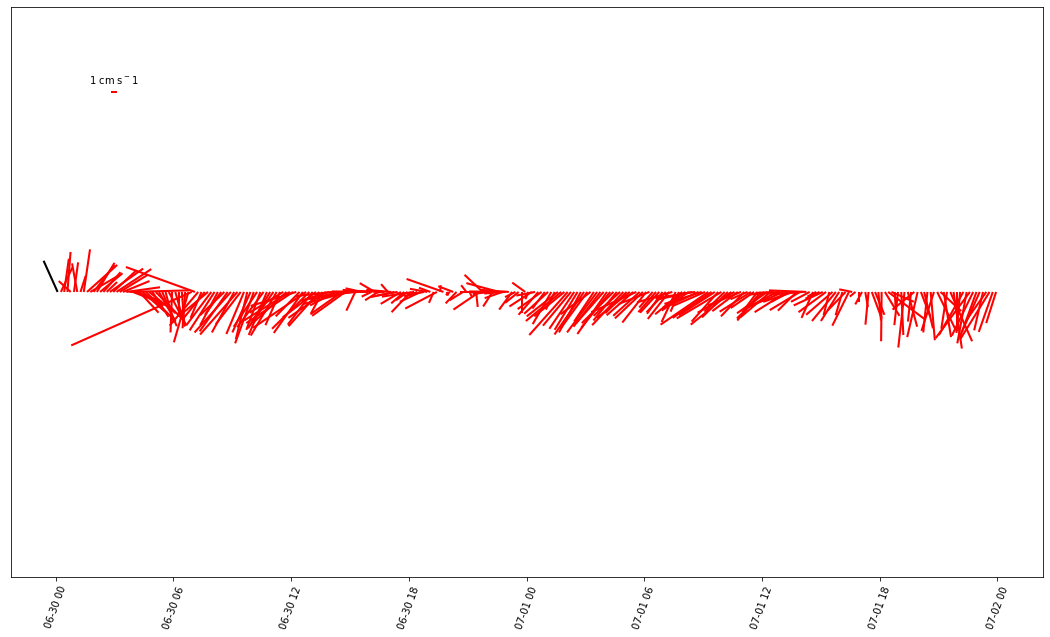



Dft qc result:       speed qcSpeedSpike
0  6.579514    112221222
d 0    112221222
Name: qcSpeedSpike, dtype: object
Stick-plot with QC
Depth: 43.11 to 46.11 m


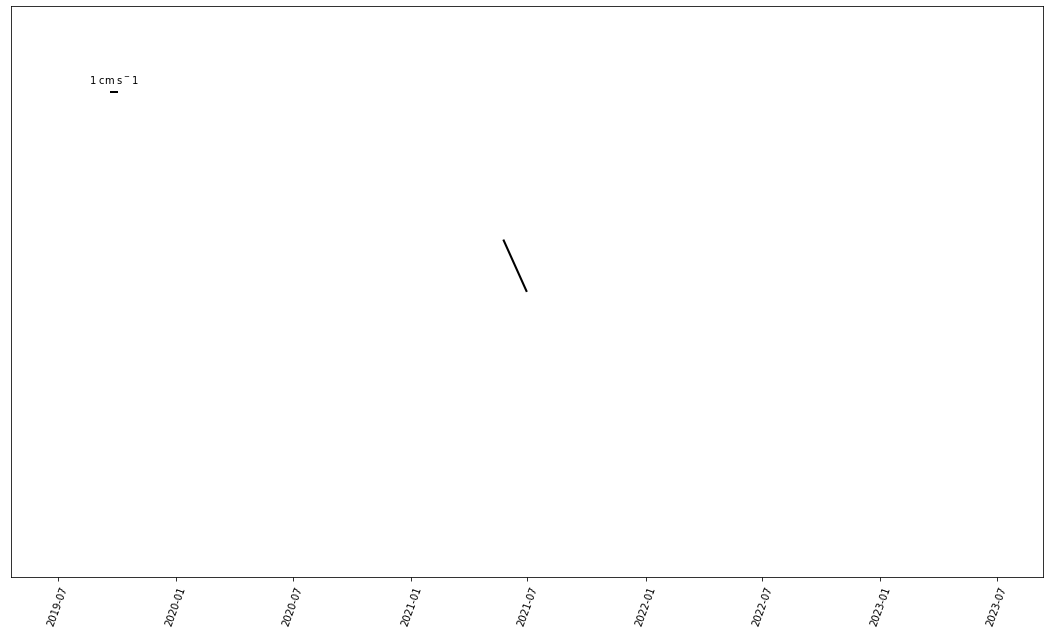



d 1657     112221222
5362     112221222
9457     112221222
13487    112221222
3217     112221222
           ...    
17647    112221222
7052     112221222
13162    112221222
7767     112221222
7507     112221222
Name: qcSpeedSpike, Length: 288, dtype: object
Stick-plot without QC
Depth: 555 to 558 m


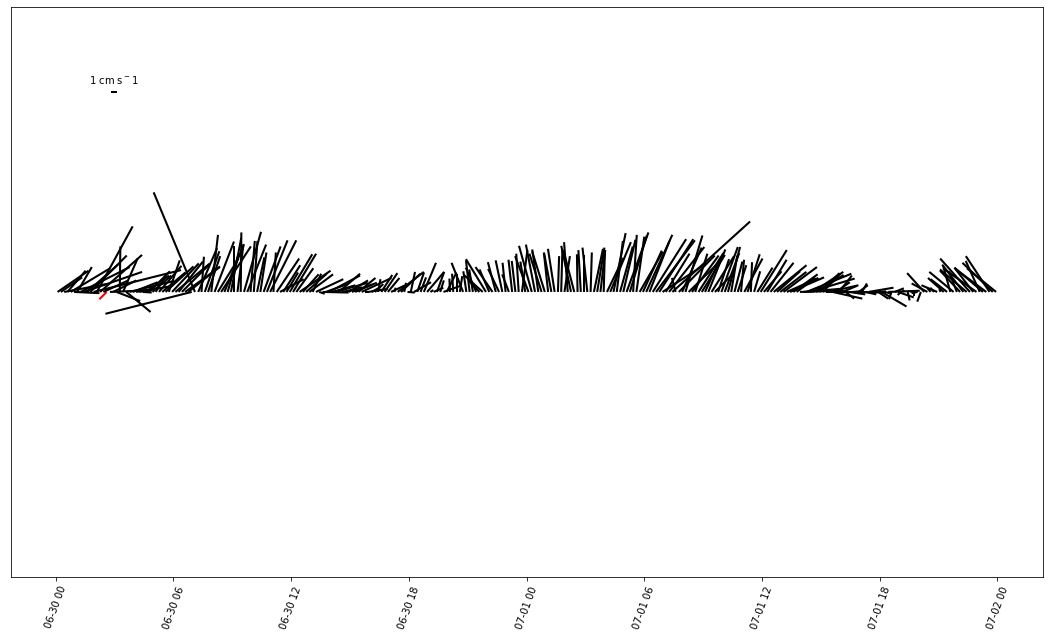



Dft qc result:           speed qcSpeedSpike
1657   5.590170    112221222
5362   3.827532    112221222
9457   7.884795    112221222
13487  5.166237    112221222
3217   6.466065    112221222
...         ...          ...
17647  3.471311    112221222
7052   3.373426    112221222
13162  5.692100    112221222
7767   3.577709    112221222
7507   1.746425    112221222

[287 rows x 2 columns]
d 1657     112221222
5362     112221222
9457     112221222
13487    112221222
3217     112221222
           ...    
17647    112221222
7052     112221222
13162    112221222
7767     112221222
7507     112221222
Name: qcSpeedSpike, Length: 287, dtype: object
Stick-plot with QC
Depth: 555 to 558 m


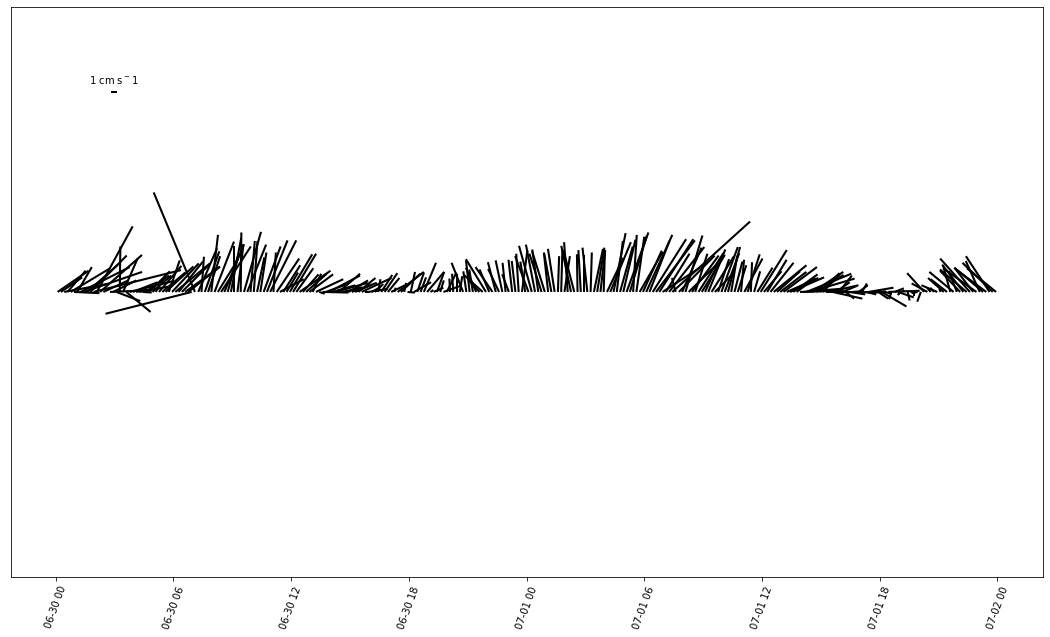



d 1688     112221222
5393     112224222
14688    112224222
3248     112221222
6628     112224222
           ...    
3963     112221222
7018     112224222
14168    112221222
7538     112224222
12738    112224222
Name: qcSpeedSpike, Length: 288, dtype: object
Stick-plot without QC
Depth: 1051 to 1054 m


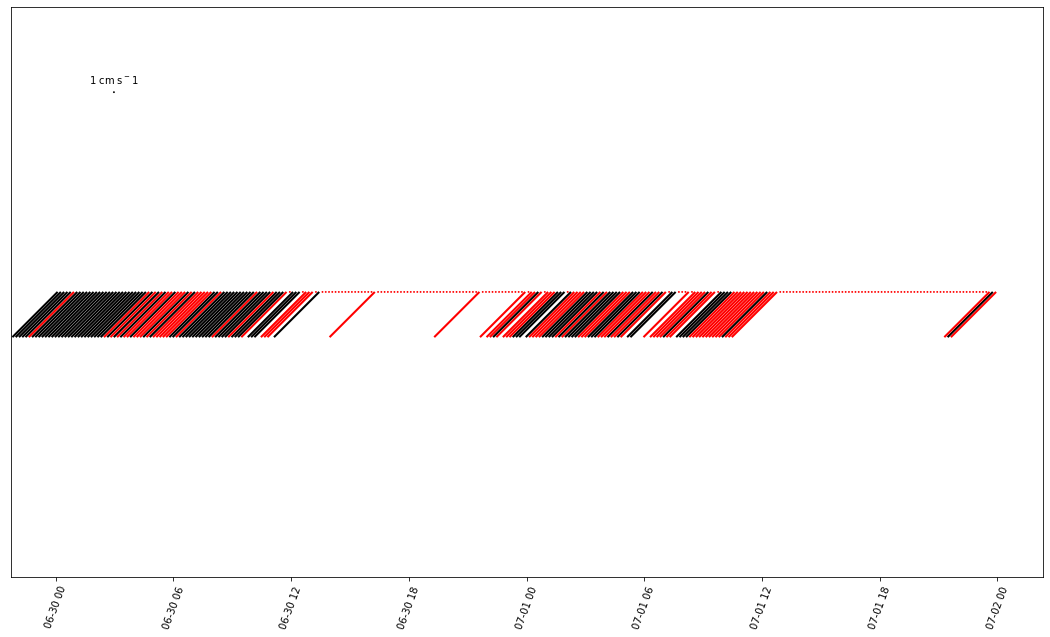



Dft qc result:         speed qcSpeedSpike
1688  -9999.0    112221222
3248  -9999.0    112221222
1948  -9999.0    112221222
10593 -9999.0    112221222
1818  -9999.0    112221222
...       ...          ...
10723 -9999.0    112221222
12283 -9999.0    112221222
11243 -9999.0    112221222
3963  -9999.0    112221222
14168 -9999.0    112221222

[84 rows x 2 columns]
d 1688     112221222
3248     112221222
1948     112221222
10593    112221222
1818     112221222
           ...    
10723    112221222
12283    112221222
11243    112221222
3963     112221222
14168    112221222
Name: qcSpeedSpike, Length: 84, dtype: object
Stick-plot with QC
Depth: 1051 to 1054 m


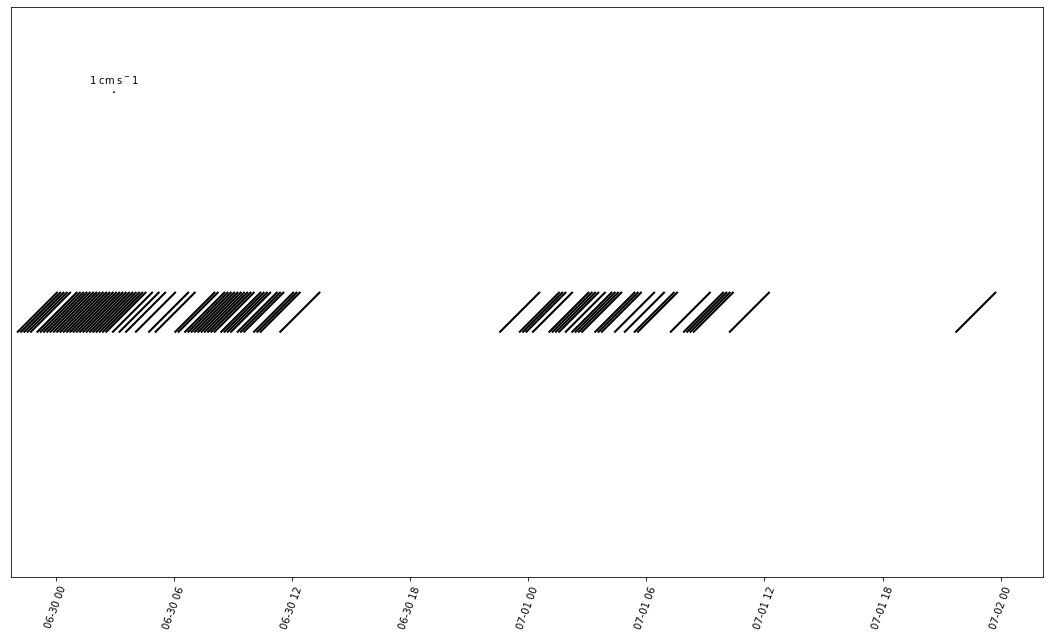

In [ ]:
#2. Spike Test - Stick Plot
df_new = df[~df.qcSpeedSpike.str.contains('3', na=False)]
df_new = df_new[~df_new.qcSpeedSpike.str.contains('4', na=False)]
df_new = df_new[~df_new.qcSpeedSpike.str.contains('9', na=False)]

print('Input data with the new column "qcResult" added for valid observations:')
print(df_new)
print("2. Spike Test")

for k in depthRanges[0:len(depthRanges)]:
  if(k==depthRanges[0] or k==depthRanges[len(depthRanges)//2] or k==depthRanges[last_dep_index]):
    dft = df[df['depth'].between(k[0], k[1])]
    # print('Depth:', k)
    q = stick_plot([t.to_pydatetime() for t in dft["time"]], dft["u"], dft["v"], dft["qcSpeedSpike"])

    ref = 1
    qk = plt.quiverkey(
        q, 0.1, 0.85, ref, f"{ref} cm s$^{-1}$", labelpos="N", coordinates="axes"
    )
    plt.xticks(rotation=70)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5, forward=True)
    print('Stick-plot without QC')
    print('Depth: {} to {} m'.format(k[0],k[1]))
    plt.show()
    print('\n')

    dft_new = df_new[df_new['depth'].between(k[0], k[1])]
    print('Dft qc result:', dft_new[["speed","qcSpeedSpike"]])
    q = stick_plot([t.to_pydatetime() for t in dft_new["time"]], dft_new["u"], dft_new["v"], dft_new["qcSpeedSpike"])

    ref = 1
    qk = plt.quiverkey(
        q, 0.1, 0.85, ref, f"{ref} cm s$^{-1}$", labelpos="N", coordinates="axes"
    )
    plt.xticks(rotation=70)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5, forward=True)
    print('Stick-plot with QC')
    print('Depth: {} to {} m'.format(k[0],k[1]))
    print(df[(df['depth'] >= k[0]) & (df['depth'] <= k[1])]['qc_overall'])
    plt.show()
    print('\n')

In [ ]:
#3. rate of change - QC

def rate_of_change_test(dataInput : Sequence[N],tdataInput : Sequence[N], threshold : float) -> np.ma.core.MaskedArray:
    
    flag_combined = list()
    countBins = len(dfInit.binNumber.unique())
    xbin = dfInit.binNumber.unique()
    flag=list()
    # print(xbin.tolist())
    for i in xbin[0:]:
      dfobs = dfInit.loc[dfInit['binNumber'] == i]
      dataInput = dfobs["speed"].values.tolist()
      
      date_list = dfobs["observationDate"].values.tolist()

      import datetime
      import time
      for index,i in enumerate(date_list):
        d=datetime.datetime.strptime(i, "%Y-%m-%dT%H:%M:%SZ")
        date_list[index]=d

      from datetime import datetime
      for index, i in enumerate(date_list):
        timestamp = datetime.timestamp(i)
        date_list[index]=int(timestamp)

      tdataInput = np.array(date_list)
      flag_output = [2]*len(dataInput)
      dataInput = np.ma.masked_invalid(np.array(dataInput).astype(np.float64))
      flag_output = np.ma.ones(dataInput.size, dtype='uint8')
      rc = np.ma.zeros(dataInput.size, dtype='float')
      # tdataInput = mapdates(tdataInput).flatten()
      rc[1:] = np.abs(np.diff(dataInput) / np.diff(tdataInput).astype('timedelta64[s]').astype(float))
      
      # print(rc)
      for i in range(0, len(flag_output)):
        if(rc[i]>threshold):
          flag_output[i]=SUSPECT
        else:
          flag_output[i]=GOOD
      flag_combined.append(flag_output)

    
    
    for k in range(0, len(flag_output)):
      for i in flag_combined:
        flag.append(i[k])

    return flag




default_qc = list("112222222")
default_qc_direction = list("112222222")
print("3.Rate of Change Test")
date_list = dfInit["observationDate"].values.tolist()

import datetime
import time
for index,i in enumerate(date_list):
  d=datetime.datetime.strptime(i, "%Y-%m-%dT%H:%M:%SZ")
  date_list[index]=d

from datetime import datetime
for index, i in enumerate(date_list):
  timestamp = datetime.timestamp(i)
  date_list[index]=int(timestamp)

results = rate_of_change_test(
    dataInput=current_list,
    tdataInput=date_list,
    threshold=0.1
)
results_direction = rate_of_change_test(
    dataInput=direction_list,
    tdataInput=date_list,
    threshold=0.1
)

qc_overall = list(results)
qc_overall_direction = list(results_direction)

#speed
for i in range(0, len(qc_overall)):
  #Rate of Change Test qc is in 7th position
  default_qc[6]=str(qc_overall[i])
  #converting list to string
  qc_overall[i] = "".join(default_qc)

result_qc7 = qc_overall
for i in range(0, len(qc_all)):
  qc_all[i] = list(qc_all[i])
  qc_all[i][6]=str(result_qc7[i][6])
  #converting list to string
  qc_all[i] = "".join(qc_all[i])

qc_overall = qc_all
dfInit['qcResult'] = qc_overall
print('QC Result: ', results)

#direction
for i in range(0, len(qc_overall_direction)):
  #Rate of Change Test qc is in 7th position
  default_qc_direction[6]=str(qc_overall_direction[i])
  #converting list to string
  qc_overall_direction[i] = "".join(default_qc_direction)

result_direction_qc7 = qc_overall_direction
for i in range(0, len(qc_direction_all)):
  qc_direction_all[i] = list(qc_direction_all[i])
  qc_direction_all[i][6]=str(result_direction_qc7[i][6])
  #converting list to string
  qc_direction_all[i] = "".join(qc_direction_all[i])

qc_overall_direction = qc_direction_all

dfInit['qcResult2'] = qc_overall_direction
print('QC Result direction: ', results_direction)


df = dfInit.rename(columns={'observationDate': 'time','loc_lon': 'longitude','loc_lat': 'latitude','verticalDatum': 'depth','Veast': 'u','Vnorth': 'v'})
df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S")
df['qcSpeedROC']=result_qc7

mind = df['depth'].min()
maxd = df['depth'].max()
print('min depth: ',df['depth'].min())
print('max depth: ',df['depth'].max())

depthRanges = []
temp =-1
k =0
df = df.sort_values('depth')

for i in df['depth'].unique():
  if temp==-1:
    temp = i
    depthRanges.append([i,i+3])
  else:
    result= i-temp
    temp = i
    if result>3:
        k=k+1
        depthRanges.append([int(temp), int(temp+3)])

print(depthRanges)

print('Input data with the new column "qcResult" added:')
df["qc_overall"] = df[['qcResult', 'qcResult2']].agg(','.join, axis=1)
print(df)

3.Rate of Change Test
QC Result:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,

Input data with the new column "qcResult" added for valid observations:
       sensorId                      time  ...  qcSpeedROC           qc_overall
5330       3028 2021-06-30 13:46:00+00:00  ...   112222122  112124122,112124122
1625       3028 2021-06-30 04:16:00+00:00  ...   112222122  112124122,112124122
0          3028 2021-06-30 00:06:00+00:00  ...   112222122  112121122,112124122
8710       3028 2021-06-30 22:26:00+00:00  ...   112222122  112124122,112124122
17420      3028 2021-07-01 20:46:00+00:00  ...   112222122  112124122,112124122
...         ...                       ...  ...         ...                  ...
6889       3028 2021-06-30 17:36:00+00:00  ...   112222122  112424122,112424122
6824       3028 2021-06-30 17:26:00+00:00  ...   112222122  112424122,112424122
6759       3028 2021-06-30 17:16:00+00:00  ...   112222122  112424122,112424122
7214       3028 2021-06-30 18:26:00+00:00  ...   112222122  112424122,112424122
18329      3028 2021-07-01 22:56:00+00:00  ...  

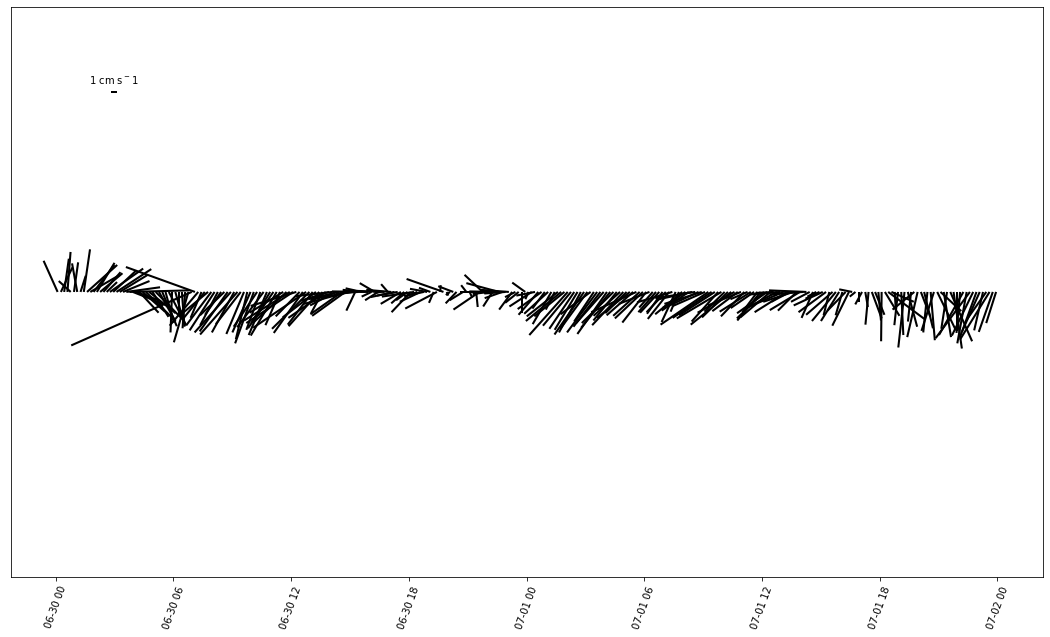



d 5330     112222122
1625     112222122
0        112222122
8710     112222122
17420    112222122
           ...    
6240     112222122
4290     112222122
15990    112222122
11765    112222122
15080    112222122
Name: qcSpeedROC, Length: 288, dtype: object
Stick-plot with QC
Depth: 43.11 to 46.11 m


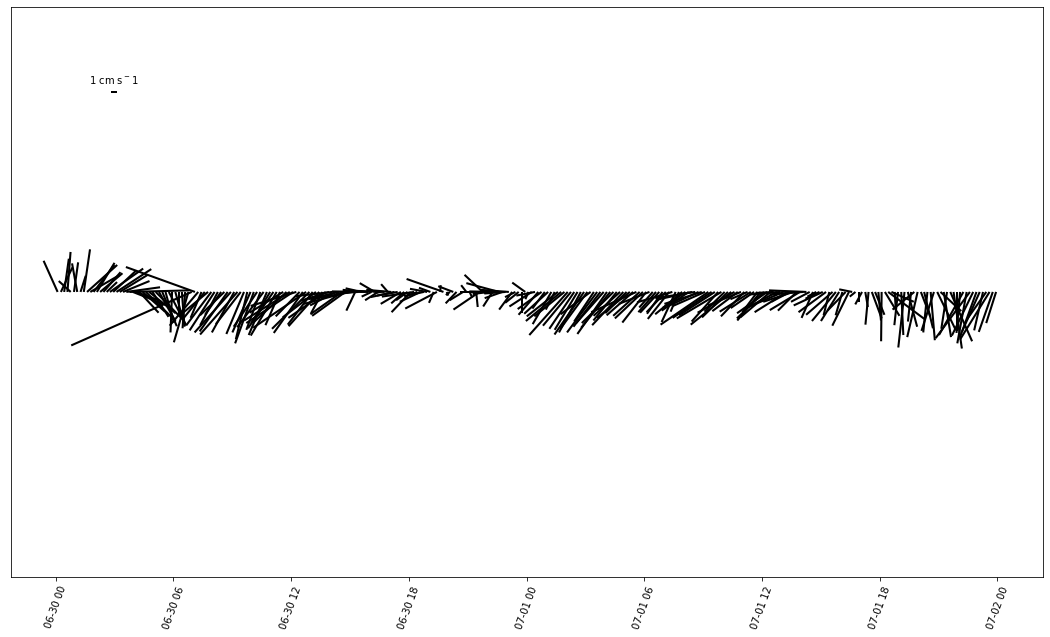



d 1657     112222122
5362     112222122
9457     112222122
13487    112222122
3217     112222122
           ...    
17647    112222122
7052     112222122
13162    112222122
7767     112222122
7507     112222122
Name: qcSpeedROC, Length: 288, dtype: object
Stick-plot without QC
Depth: 555 to 558 m


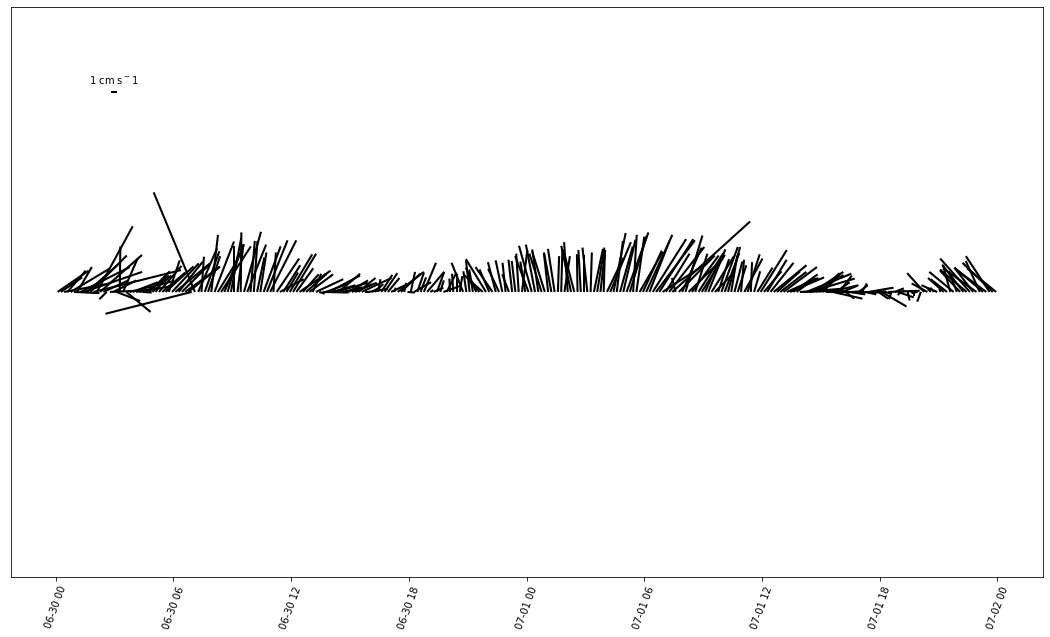



d 1657     112222122
5362     112222122
9457     112222122
13487    112222122
3217     112222122
           ...    
17647    112222122
7052     112222122
13162    112222122
7767     112222122
7507     112222122
Name: qcSpeedROC, Length: 288, dtype: object
Stick-plot with QC
Depth: 555 to 558 m


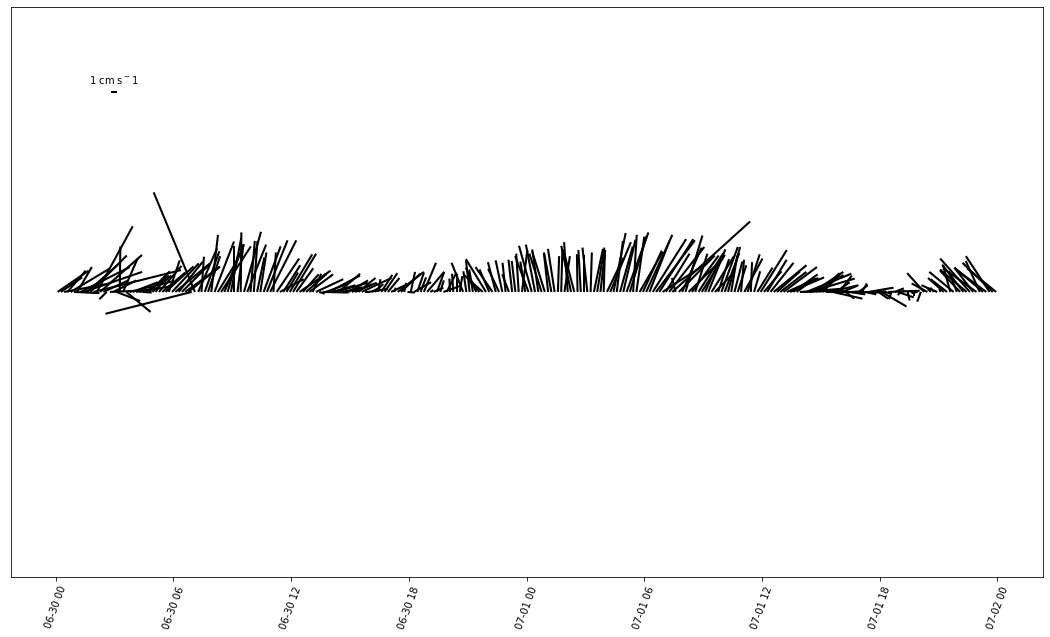



d 1688     112222122
5393     112222122
14688    112222122
3248     112222122
6628     112222122
           ...    
3963     112222122
7018     112222122
14168    112222122
7538     112222122
12738    112222322
Name: qcSpeedROC, Length: 288, dtype: object
Stick-plot without QC
Depth: 1051 to 1054 m


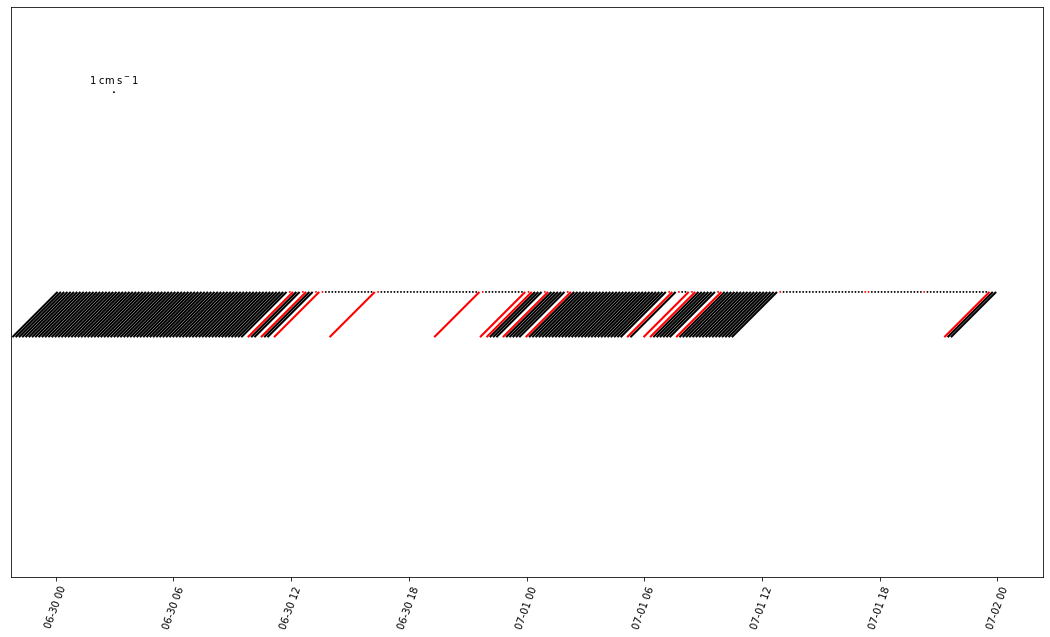



d 1688     112222122
5393     112222122
14688    112222122
3248     112222122
6628     112222122
           ...    
15793    112222122
3963     112222122
7018     112222122
14168    112222122
7538     112222122
Name: qcSpeedROC, Length: 257, dtype: object
Stick-plot with QC
Depth: 1051 to 1054 m


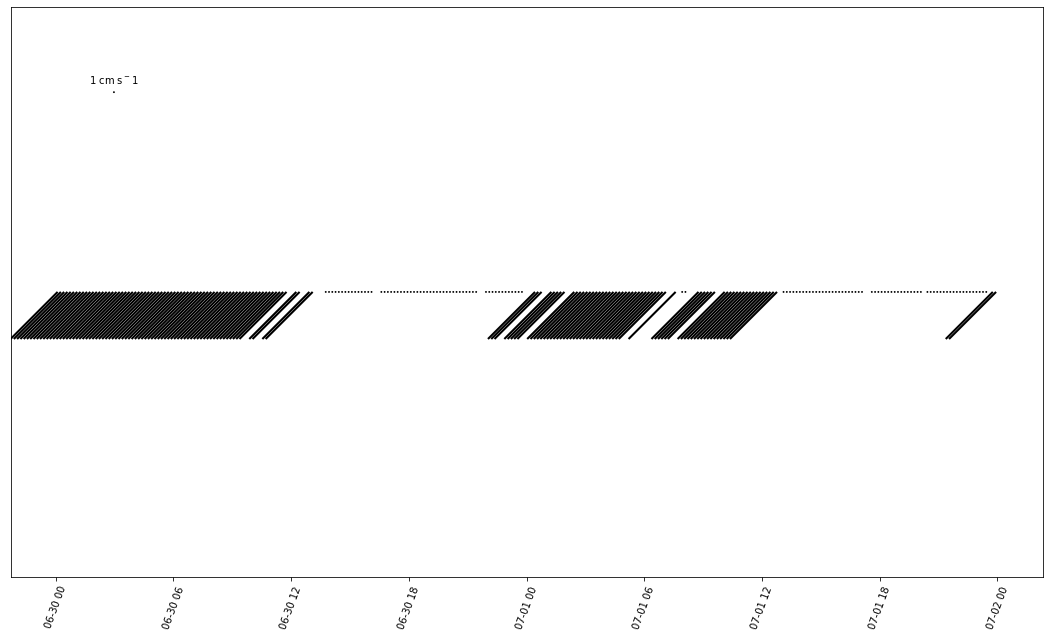

In [ ]:
#3. rate of change - Stick Plot
df_new = df[~df.qcSpeedROC.str.contains('3', na=False)]
df_new = df_new[~df_new.qcSpeedROC.str.contains('4', na=False)]
df_new = df_new[~df_new.qcSpeedROC.str.contains('9', na=False)]
print('Input data with the new column "qcResult" added for valid observations:')
print(df_new)
print("3. Rate of Change Test")

for k in depthRanges[0:len(depthRanges)]:
  if(k==depthRanges[0] or k==depthRanges[len(depthRanges)//2] or k==depthRanges[last_dep_index]):
    dft = df[df['depth'].between(k[0], k[1])]
    # print('Depth:', k)
    q = stick_plot([t.to_pydatetime() for t in dft["time"]], dft["u"], dft["v"], dft["qcSpeedROC"])

    ref = 1
    qk = plt.quiverkey(
        q, 0.1, 0.85, ref, f"{ref} cm s$^{-1}$", labelpos="N", coordinates="axes"
    )
    plt.xticks(rotation=70)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5, forward=True)
    print('Stick-plot without QC')
    print('Depth: {} to {} m'.format(k[0],k[1]))
    plt.show()
    print('\n')

    dft_new = df_new[df_new['depth'].between(k[0], k[1])]
    # print('Depth:', k)
    q = stick_plot([t.to_pydatetime() for t in dft_new["time"]], dft_new["u"], dft_new["v"], dft_new["qcSpeedROC"])

    ref = 1
    qk = plt.quiverkey(
        q, 0.1, 0.85, ref, f"{ref} cm s$^{-1}$", labelpos="N", coordinates="axes"
    )
    plt.xticks(rotation=70)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5, forward=True)
    print('Stick-plot with QC')
    print('Depth: {} to {} m'.format(k[0],k[1]))
    plt.show()
    print('\n')

In [ ]:
#4. flat line test - QC
def flat_line_test(dataInput: Sequence[N],tdataInput: Sequence[N],suspect_threshold: int,fail_threshold: int,
                   tolerance: N = 0) -> np.ma.MaskedArray:

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        dataInput = np.ma.masked_invalid(np.array(dataInput).astype(np.float64))

    # Save initial shape
    initial_shape = dataInput.shape
    dataInput = dataInput.flatten()

    # Start with everything as passing
    flag_output = np.full((dataInput.size,), GOOD)

    # if we have fewer than 3 points, we can't run the test, so everything passes
    if len(dataInput) < 3:
        return flag_output.reshape(initial_shape)

    # The thresholds are in seconds so we round make sure the interval is also in seconds
    time_interval = np.median(np.diff(tdataInput)).astype('timedelta64[s]').astype(float)
    fill_value=-99999
    valid_rep_cnt_fail=fail_threshold
    valid_rep_cnt_suspect=suspect_threshold
    EPS = tolerance

    indx1=[];
    indx2=[];
    var_temp=dataInput;

    for i in range(suspect_threshold,len(dataInput)):
      k=1
      check1=0
      while k<=valid_rep_cnt_suspect-1:
          if abs(var_temp[i]-var_temp[i-k])<=EPS:
              check1=check1+1
          k=k+1
      if check1==(valid_rep_cnt_suspect-1):
          if (flag_output[i]==1 or flag_output[i]==3):
              flag_output[i]=3
              indx1=[indx1,i]

    for i in range(fail_threshold,len(dataInput)):
      k=1
      check1=0
      while (k<=valid_rep_cnt_fail-1):
          if abs(var_temp[i]-var_temp[i-k])<=EPS:
              check1=check1+1
          k=k+1;
      if (check1==valid_rep_cnt_fail-1):
          if (flag_output[i]==1 or flag_output[i]==3):
              flag_output[i]=4
              indx2=[indx2,i]
              dataInput[i]=fill_value

  
    flag_output[dataInput.mask] = MISSING

    return flag_output.reshape(initial_shape)

default_qc = list("112222222")
default_qc_direction = list("112222222")
print("4.Flat Line Test")
date_list = dfInit["observationDate"].values.tolist()

import datetime
import time
for index,i in enumerate(date_list):
  d=datetime.datetime.strptime(i, "%Y-%m-%dT%H:%M:%SZ")
  date_list[index]=d

from datetime import datetime
for index, i in enumerate(date_list):
  timestamp = datetime.timestamp(i)
  date_list[index]=int(timestamp)

results = flat_line_test(
    dataInput=np.array(current_list),
    tdataInput=np.array(date_list),
    tolerance=2,  
    fail_threshold=5,
    suspect_threshold=3
)
results_direction = flat_line_test(
    dataInput=np.array(direction_list),
    tdataInput=np.array(date_list),
    tolerance=2,  
    fail_threshold=5,
    suspect_threshold=3
)

qc_overall = list(results)
qc_overall_direction = list(results_direction)

#speed
for i in range(0, len(qc_overall)):
  #Flat Line Test qc is in 8th position
  default_qc[7]=str(qc_overall[i])
  #converting list to string
  qc_overall[i] = "".join(default_qc)

result_qc8 = qc_overall
for i in range(0, len(qc_all)):
  qc_all[i] = list(qc_all[i])
  qc_all[i][7]=str(result_qc8[i][7])
  #converting list to string
  qc_all[i] = "".join(qc_all[i])

qc_overall = qc_all
dfInit['qcResult'] = qc_overall
print('QC Result: ', results)

#direction
for i in range(0, len(qc_overall_direction)):
  #Flat Line Test qc is in 8th position
  default_qc_direction[7]=str(qc_overall_direction[i])
  #converting list to string
  qc_overall_direction[i] = "".join(default_qc_direction)

result_direction_qc8 = qc_overall_direction
for i in range(0, len(qc_direction_all)):
  qc_direction_all[i] = list(qc_direction_all[i])
  qc_direction_all[i][7]=str(result_direction_qc8[i][7])
  #converting list to string
  qc_direction_all[i] = "".join(qc_direction_all[i])

qc_overall_direction = qc_direction_all

dfInit['qcResult2'] = qc_overall_direction
print('QC Result direction: ', results_direction)

df = dfInit.rename(columns={'observationDate': 'time','loc_lon': 'longitude','loc_lat': 'latitude','verticalDatum': 'depth','Veast': 'u','Vnorth': 'v'})
df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S")
df['qcSpeedFLT'] = result_qc8

mind = df['depth'].min()
maxd = df['depth'].max()
print('min depth: ',df['depth'].min())
print('max depth: ',df['depth'].max())

depthRanges = []
temp =-1
k =0
df = df.sort_values('depth')

for i in df['depth'].unique():
  if temp==-1:
    temp = i
    depthRanges.append([i,i+3])
  else:
    result= i-temp
    temp = i
    if result>3:
        k=k+1
        depthRanges.append([int(temp), int(temp+3)])

print(depthRanges)

print('Input data with the new column "qcResult" added:')
df["qc_overall"] = df[['qcResult', 'qcResult2']].agg(','.join, axis=1)
print(df)

4.Flat Line Test
QC Result:  [1 1 1 ... 1 1 1]
QC Result direction:  [1 1 1 ... 1 1 1]
min depth:  43.11
max depth:  1067.13
[[43.11, 46.11], [59, 62], [75, 78], [91, 94], [107, 110], [123, 126], [139, 142], [155, 158], [171, 174], [187, 190], [203, 206], [219, 222], [235, 238], [251, 254], [267, 270], [283, 286], [299, 302], [315, 318], [331, 334], [347, 350], [363, 366], [379, 382], [395, 398], [411, 414], [427, 430], [443, 446], [459, 462], [475, 478], [491, 494], [507, 510], [523, 526], [539, 542], [555, 558], [571, 574], [587, 590], [603, 606], [619, 622], [635, 638], [651, 654], [667, 670], [683, 686], [699, 702], [715, 718], [731, 734], [747, 750], [763, 766], [779, 782], [795, 798], [811, 814], [827, 830], [843, 846], [859, 862], [875, 878], [891, 894], [907, 910], [923, 926], [939, 942], [955, 958], [971, 974], [987, 990], [1003, 1006], [1019, 1022], [1035, 1038], [1051, 1054], [1067, 1070]]
Input data with the new column "qcResult" added:
       sensorId                      

Input data with the new column "qcResult" added for valid observations:
       sensorId                      time  ...  qcSpeedFLT           qc_overall
5330       3028 2021-06-30 13:46:00+00:00  ...   112222212  112124112,112124112
1625       3028 2021-06-30 04:16:00+00:00  ...   112222212  112124112,112124112
0          3028 2021-06-30 00:06:00+00:00  ...   112222212  112121112,112124112
8710       3028 2021-06-30 22:26:00+00:00  ...   112222212  112124112,112124112
17420      3028 2021-07-01 20:46:00+00:00  ...   112222212  112124112,112124112
...         ...                       ...  ...         ...                  ...
6889       3028 2021-06-30 17:36:00+00:00  ...   112222212  112424112,112424112
6824       3028 2021-06-30 17:26:00+00:00  ...   112222212  112424112,112424112
6759       3028 2021-06-30 17:16:00+00:00  ...   112222212  112424112,112424112
7214       3028 2021-06-30 18:26:00+00:00  ...   112222212  112424112,112424112
18329      3028 2021-07-01 22:56:00+00:00  ...  

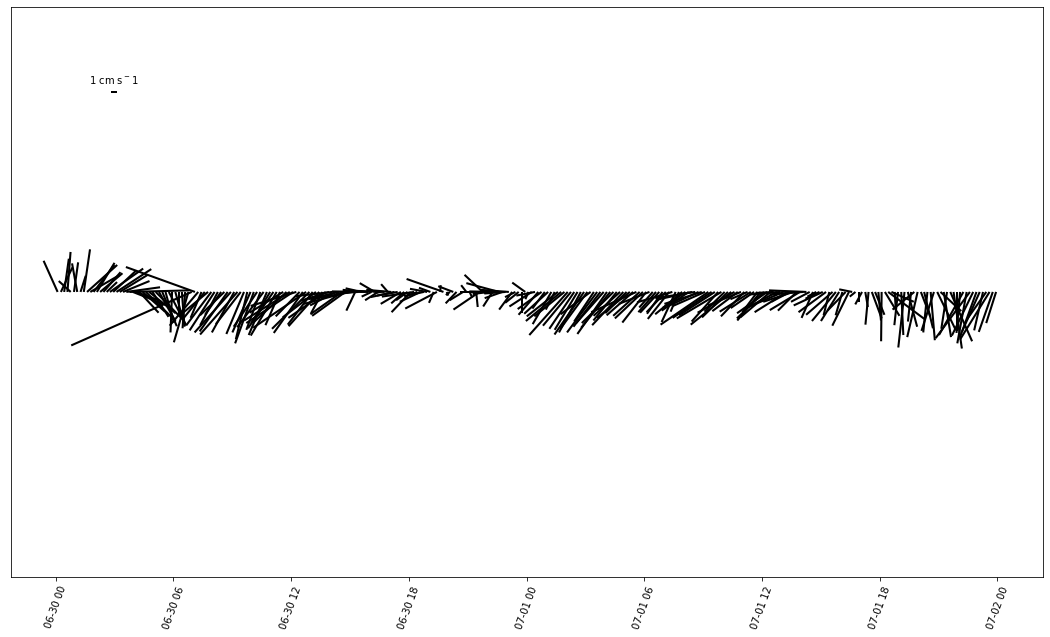



d 5330     112222212
1625     112222212
0        112222212
8710     112222212
17420    112222212
           ...    
6240     112222212
4290     112222212
15990    112222212
11765    112222212
15080    112222212
Name: qcSpeedFLT, Length: 288, dtype: object
Stick-plot with QC
Depth: 43.11 to 46.11 m


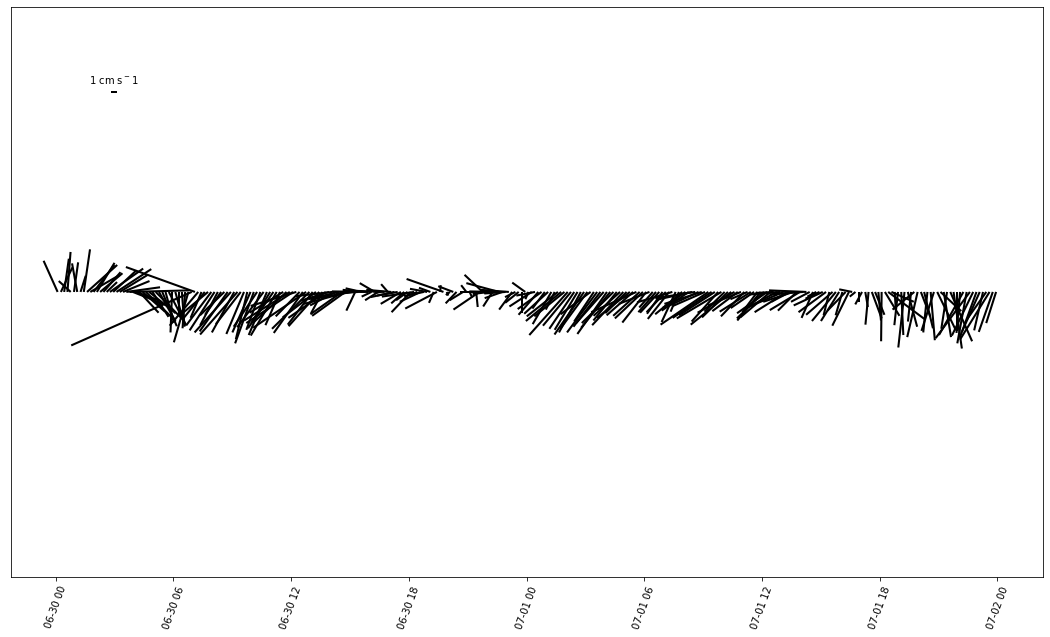



d 1657     112222212
5362     112222212
9457     112222242
13487    112222232
3217     112222212
           ...    
17647    112222212
7052     112222242
13162    112222232
7767     112222212
7507     112222232
Name: qcSpeedFLT, Length: 288, dtype: object
Stick-plot without QC
Depth: 555 to 558 m


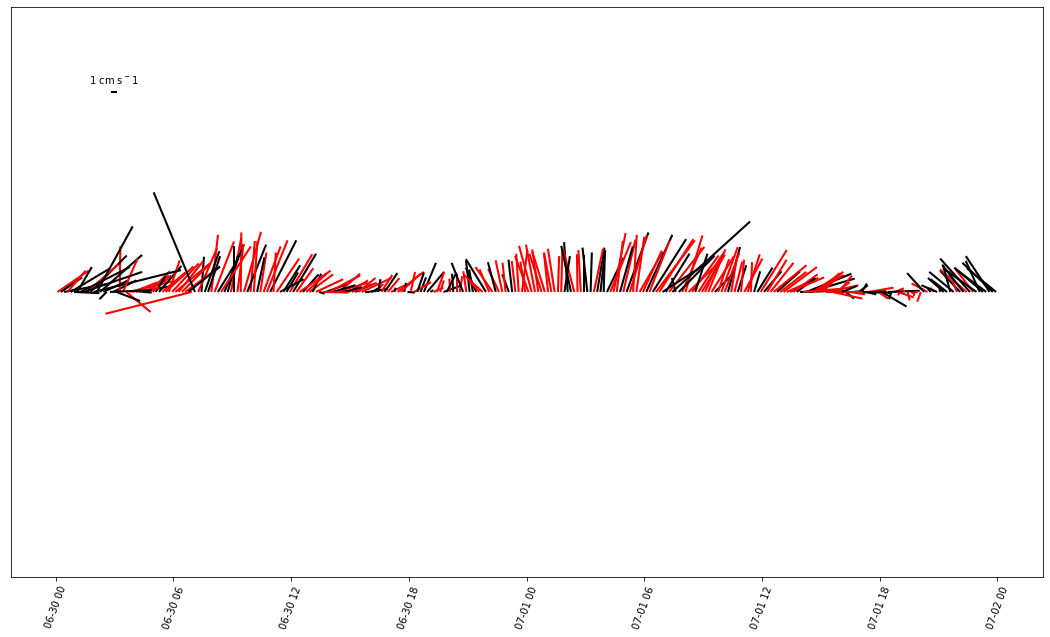



d 1657     112222212
5362     112222212
3217     112222212
8547     112222212
1137     112222212
           ...    
7377     112222212
7182     112222212
6987     112222212
17647    112222212
7767     112222212
Name: qcSpeedFLT, Length: 130, dtype: object
Stick-plot with QC
Depth: 555 to 558 m


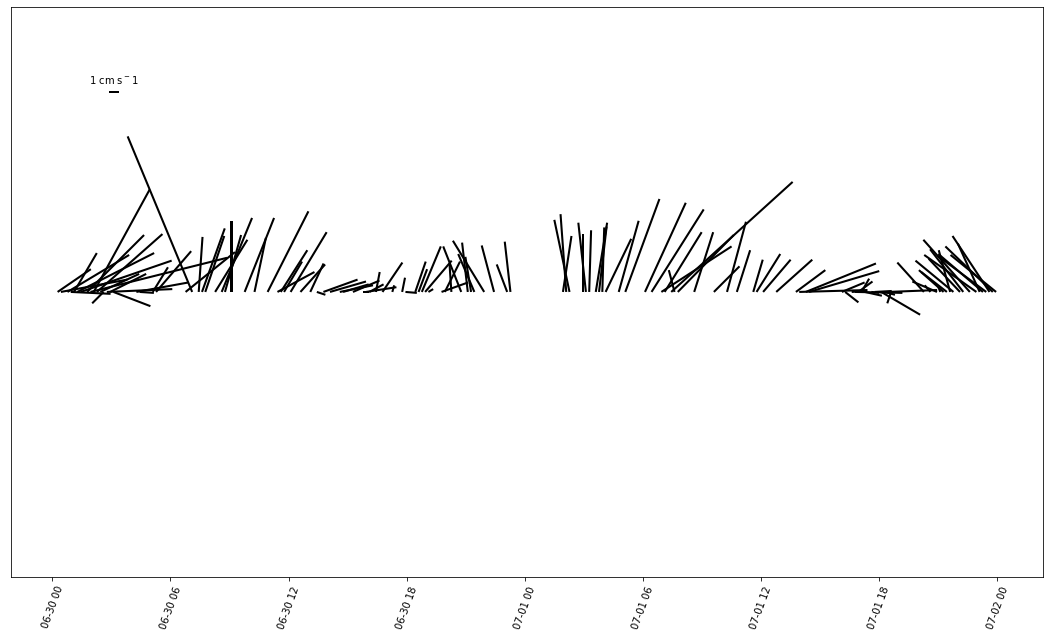



d 1688     112222232
5393     112222212
14688    112222212
3248     112222212
6628     112222212
           ...    
3963     112222212
7018     112222212
14168    112222212
7538     112222232
12738    112222212
Name: qcSpeedFLT, Length: 288, dtype: object
Stick-plot without QC
Depth: 1051 to 1054 m


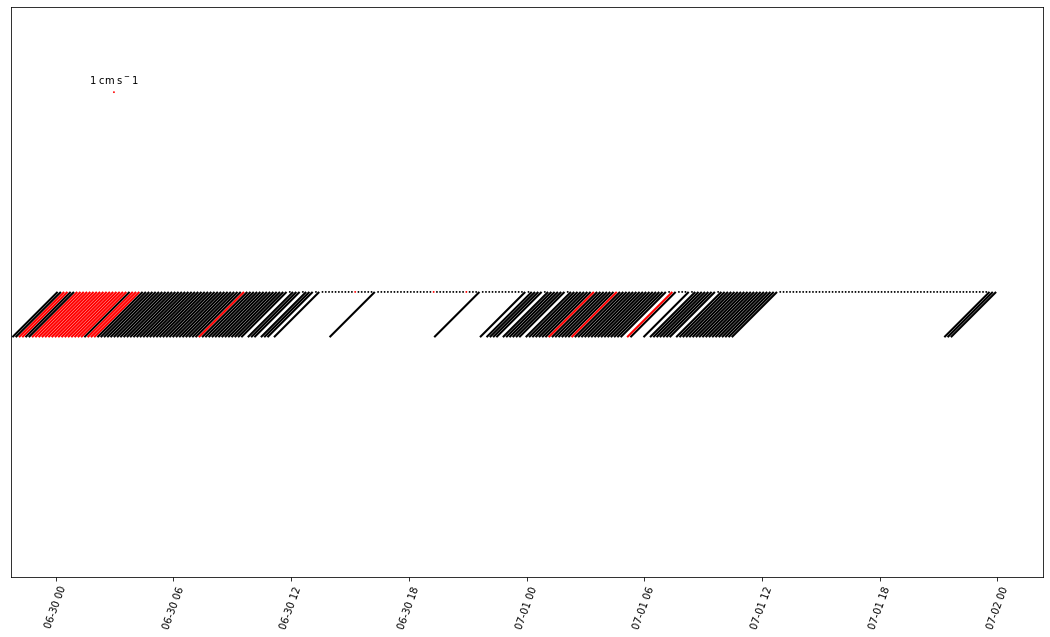



d 5393     112222212
14688    112222212
3248     112222212
6628     112222212
1948     112222212
           ...    
6433     112222212
3963     112222212
7018     112222212
14168    112222212
12738    112222212
Name: qcSpeedFLT, Length: 260, dtype: object
Stick-plot with QC
Depth: 1051 to 1054 m


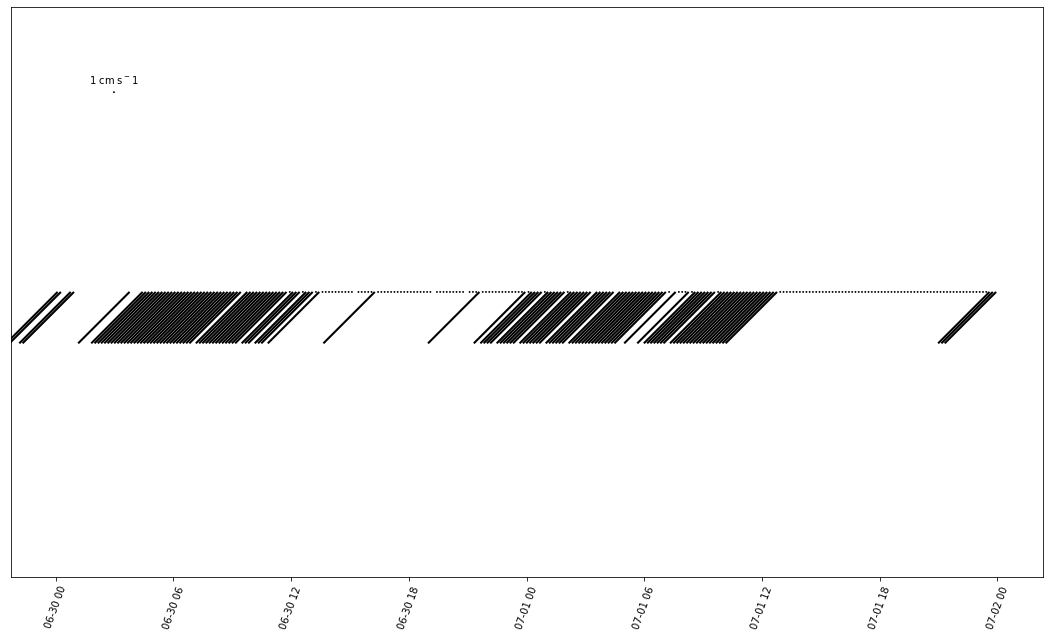

In [ ]:
#4. flat line test - Stick Plot
df_new = df[~df.qcSpeedFLT.str.contains('3', na=False)]
df_new = df_new[~df_new.qcSpeedFLT.str.contains('4', na=False)]
df_new = df_new[~df_new.qcSpeedFLT.str.contains('9', na=False)]
print('Input data with the new column "qcResult" added for valid observations:')
print(df_new)
print("4. Flat Line Test")

for k in depthRanges[0:len(depthRanges)]:
  if(k==depthRanges[0] or k==depthRanges[len(depthRanges)//2] or k==depthRanges[last_dep_index]):
    dft = df[df['depth'].between(k[0], k[1])]
    # print('Depth:', k)
    q = stick_plot([t.to_pydatetime() for t in dft["time"]], dft["u"], dft["v"], dft["qcSpeedFLT"])

    ref = 1
    qk = plt.quiverkey(
        q, 0.1, 0.85, ref, f"{ref} cm s$^{-1}$", labelpos="N", coordinates="axes"
    )
    plt.xticks(rotation=70)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5, forward=True)
    print('Stick-plot without QC')
    print('Depth: {} to {} m'.format(k[0],k[1]))
    plt.show()
    print('\n')

    dft_new = df_new[df_new['depth'].between(k[0], k[1])]
    # print('Depth:', k)
    q = stick_plot([t.to_pydatetime() for t in dft_new["time"]], dft_new["u"], dft_new["v"], dft_new["qcSpeedFLT"])

    ref = 1
    qk = plt.quiverkey(
        q, 0.1, 0.85, ref, f"{ref} cm s$^{-1}$", labelpos="N", coordinates="axes"
    )
    plt.xticks(rotation=70)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5, forward=True)
    print('Stick-plot with QC')
    print('Depth: {} to {} m'.format(k[0],k[1]))
    plt.show()
    print('\n')

In [ ]:
#5. echo intensity test - QC
def echo_intensity_test(observationDates):
  flag_output = list()
  for index, k in enumerate(observationDates):
    dfObs = dfInit.loc[dfInit['observationDate'] == k]
    countBins = len(dfObs.binNumber.unique())
    flag_output_unit = np.full((len(dfObs.binNumber.unique()),), GOOD)
    
    for i in range(2,countBins):   
      badBeam =0 
      if(abs(dfObs.iloc[i]['echoIntensityB1'] - dfObs.iloc[i-1]['echoIntensityB1'])>25):
        badBeam+=1
      if(abs(dfObs.iloc[i]['echoIntensityB2'] - dfObs.iloc[i-1]['echoIntensityB2'])>25):
        badBeam+=1
      if(abs(dfObs.iloc[i]['echoIntensityB3'] - dfObs.iloc[i-1]['echoIntensityB3'])>25):
        badBeam+=1
      if(abs(dfObs.iloc[i]['echoIntensityB4'] - dfObs.iloc[i-1]['echoIntensityB4'])>25):
        badBeam+=1

      if (dfObs['echoIntensityB4'] == 0).all():
        if badBeam>2:
          flag_output_unit[i]=4
        elif badBeam==2:
          flag_output_unit[i]=3
        elif badBeam<=1:
          flag_output_unit[i]=1
      else:
        if badBeam>=2:
          flag_output_unit[i]=4
        elif badBeam==1:
          flag_output_unit[i]=3
        elif badBeam==0:
          flag_output_unit[i]=1
    
  
    flag_output = flag_output + list(flag_output_unit)
  
  print(flag_output)
  flag_output[0] = UNKNOWN
  flag_output[-1] = UNKNOWN
  flag_output = np.ma.asarray(flag_output)
  return flag_output

default_qc = list("112222222")

print("5.Echo Intensity Test")
observationDates = dfInit["observationDate"].unique()
results = echo_intensity_test(observationDates)

qc_overall = list(results)

for i in range(0, len(qc_overall)):
  #Echo Intensity qc is in 9th position
  default_qc[8]=str(qc_overall[i])
  #converting list to string
  qc_overall[i] = "".join(default_qc)

result_qc9 = qc_overall
for i in range(0, len(qc_all)):
  qc_all[i] = list(qc_all[i])
  qc_all[i][8]=str(result_qc9[i][8])
  #converting list to string
  qc_all[i] = "".join(qc_all[i])

qc_overall = qc_all
dfInit['qcResult'] = qc_overall
print('QC Result: ', results)

df = dfInit.rename(columns={'observationDate': 'time','loc_lon': 'longitude','loc_lat': 'latitude','verticalDatum': 'depth','Veast': 'u','Vnorth': 'v'})
df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S")
df['qcEIT'] = result_qc9


mind = df['depth'].min()
maxd = df['depth'].max()
print('min depth: ',df['depth'].min())
print('max depth: ',df['depth'].max())

depthRanges = []
temp =-1
k =0
df = df.sort_values('depth')

for i in df['depth'].unique():
  if temp==-1:
    temp = i
    depthRanges.append([i,i+3])
  else:
    result= i-temp
    temp = i
    if result>3:
        k=k+1
        depthRanges.append([int(temp), int(temp+3)])

print(depthRanges)

print('Input data with the new column "qcResult" added:')
df["qc_overall"] = df[['qcResult', 'qcResult2']].agg(','.join, axis=1)
print(df)

5.Echo Intensity Test
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1,

Input data with the new column "qcResult" added for valid observations:
       sensorId                      time  ...      qcEIT           qc_overall
5330       3028 2021-06-30 13:46:00+00:00  ...  112222221  112124111,112124112
1625       3028 2021-06-30 04:16:00+00:00  ...  112222221  112124111,112124112
0          3028 2021-06-30 00:06:00+00:00  ...  112222222  112121112,112124112
8710       3028 2021-06-30 22:26:00+00:00  ...  112222221  112124111,112124112
17420      3028 2021-07-01 20:46:00+00:00  ...  112222221  112124111,112124112
...         ...                       ...  ...        ...                  ...
7018       3028 2021-06-30 17:56:00+00:00  ...  112222221  112124111,112124112
14168      3028 2021-07-01 12:16:00+00:00  ...  112222221  112421111,112421112
7538       3028 2021-06-30 19:16:00+00:00  ...  112222221  112124131,112124112
12738      3028 2021-07-01 08:36:00+00:00  ...  112222221  112424311,112424312
18719      3028 2021-07-01 23:56:00+00:00  ...  112222222  

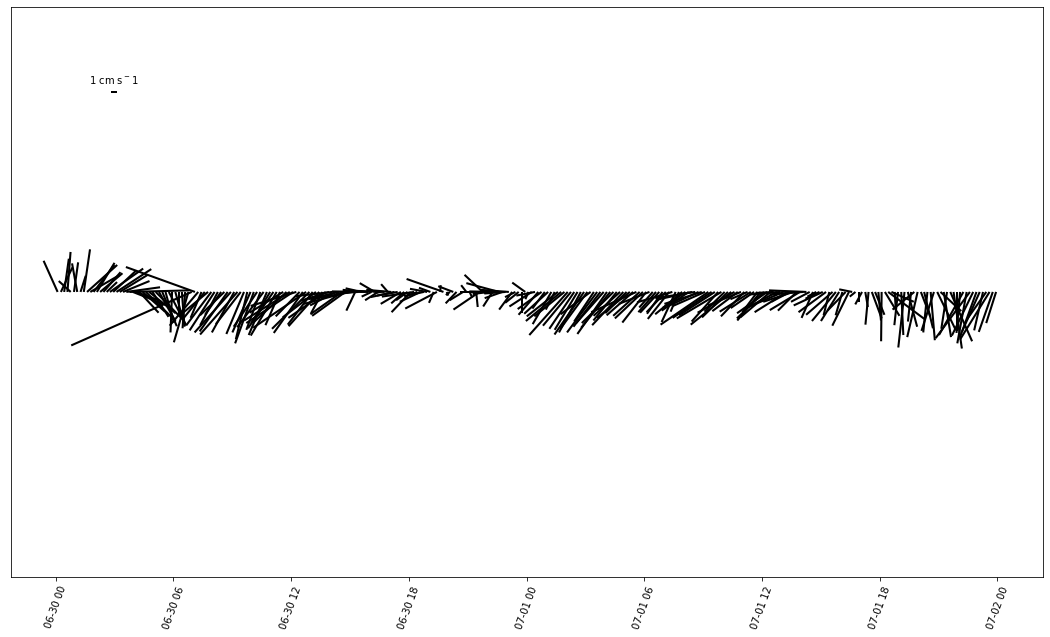



Stick-plot with QC
Depth: 43.11 to 46.11 m


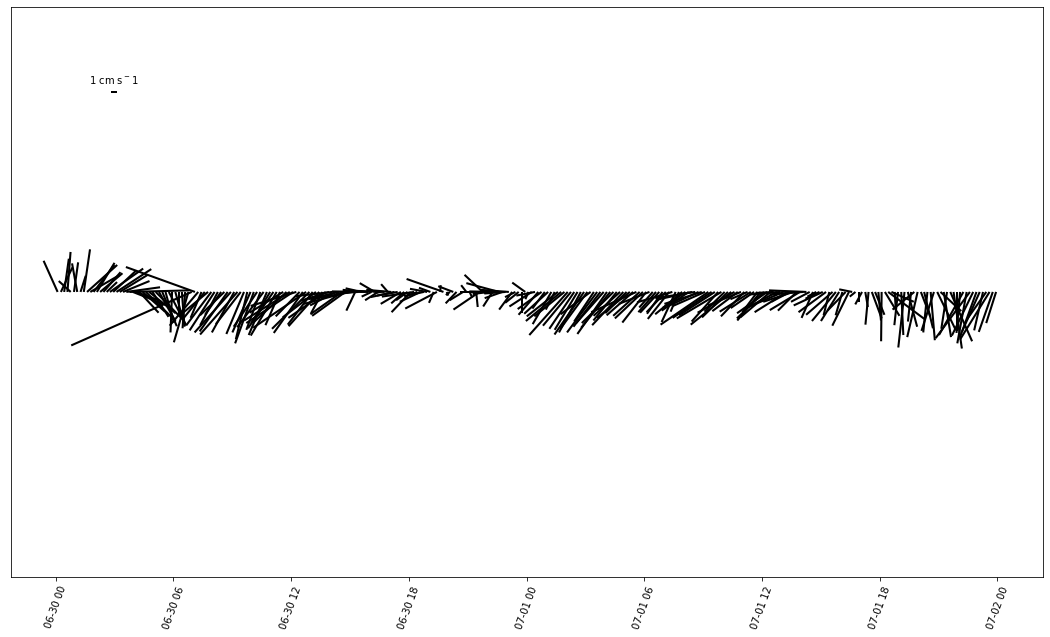



Stick-plot without QC
Depth: 555 to 558 m


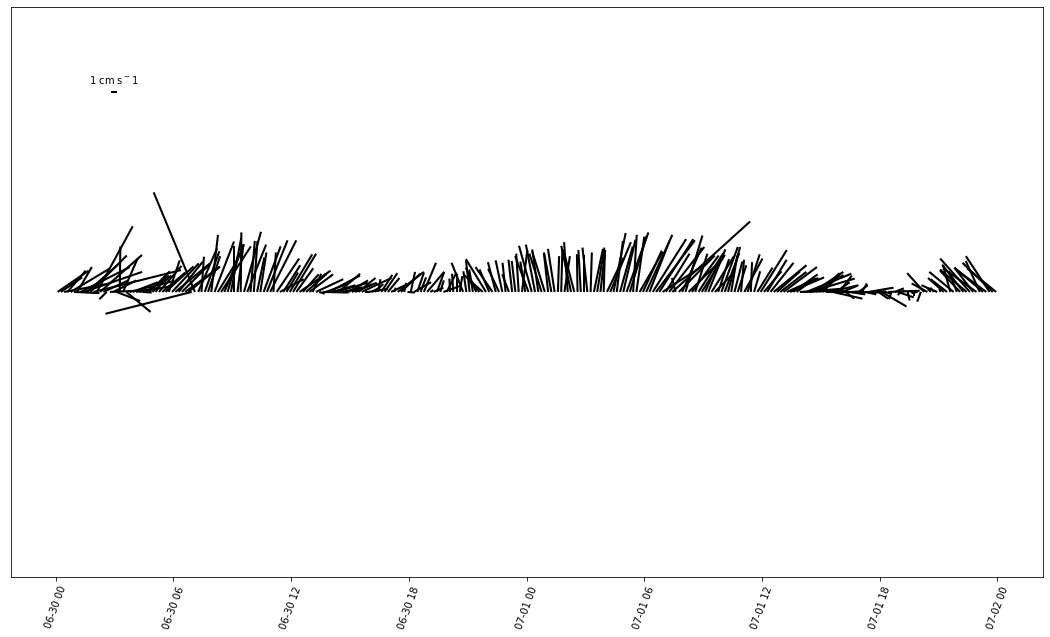



Stick-plot with QC
Depth: 555 to 558 m


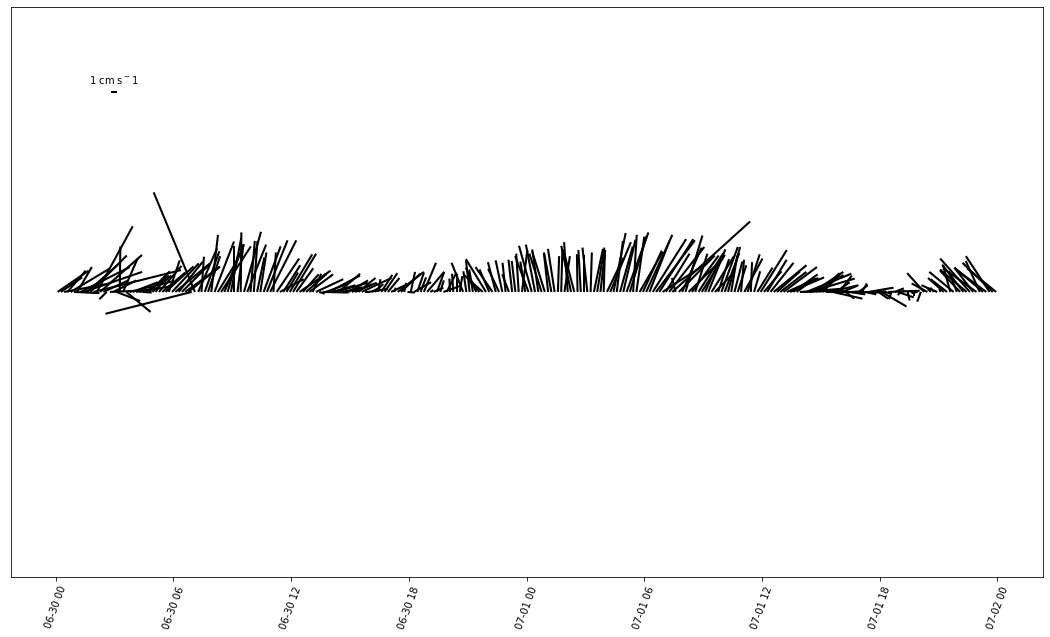



Stick-plot without QC
Depth: 1051 to 1054 m


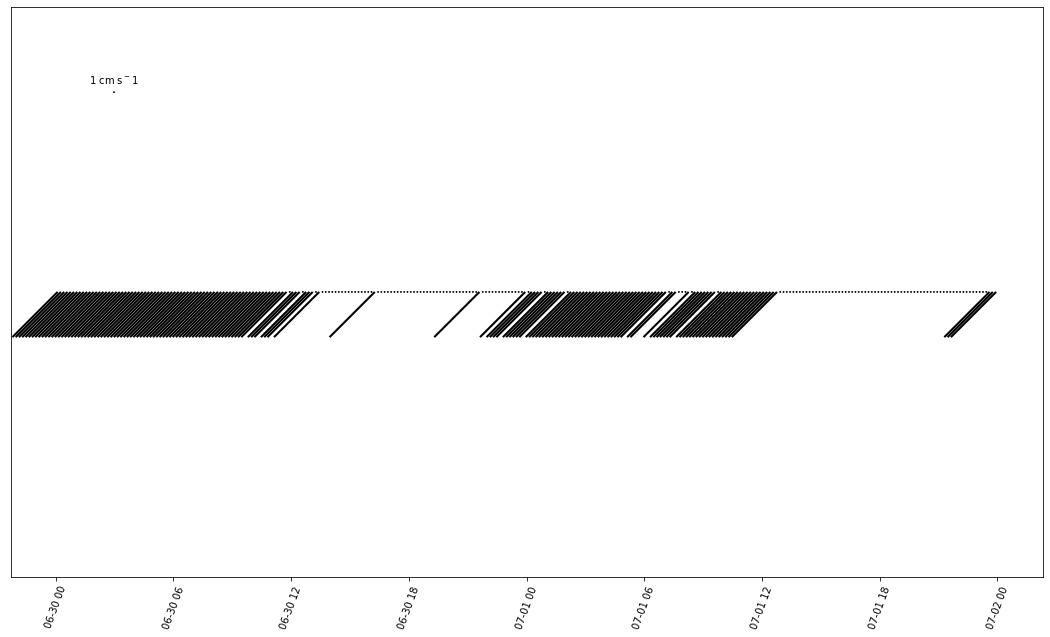



Stick-plot with QC
Depth: 1051 to 1054 m


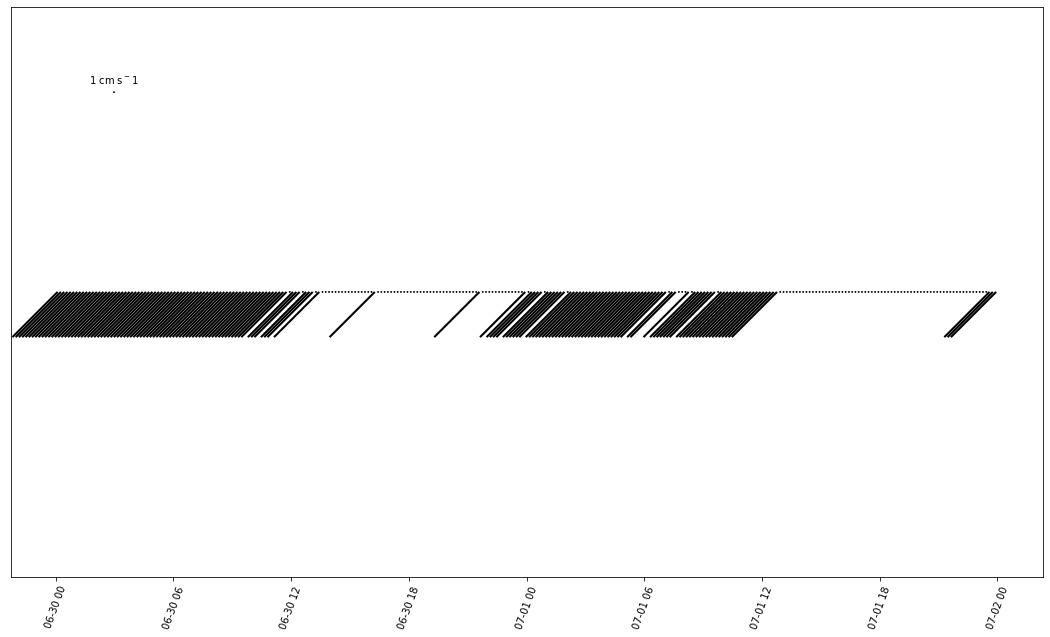

In [ ]:
#5. echo intensity test - Stick Plot
df_new = df[~df.qcEIT.str.contains('3', na=False)]
df_new = df_new[~df_new.qcEIT.str.contains('4', na=False)]
df_new = df_new[~df_new.qcEIT.str.contains('9', na=False)]
print('Input data with the new column "qcResult" added for valid observations:')
print(df_new)
print("5.Echo Intensity Test")

for k in depthRanges[0:len(depthRanges)]:
  if(k==depthRanges[0] or k==depthRanges[len(depthRanges)//2] or k==depthRanges[last_dep_index]):
    dft = df[df['depth'].between(k[0], k[1])]
    # print('Depth:', k)
    q = stick_plot([t.to_pydatetime() for t in dft["time"]], dft["u"], dft["v"], dft["qcEIT"])
    
    ref = 1
    qk = plt.quiverkey(
        q, 0.1, 0.85, ref, f"{ref} cm s$^{-1}$", labelpos="N", coordinates="axes"
    )
    plt.xticks(rotation=70)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5, forward=True)
    print('Stick-plot without QC')
    print('Depth: {} to {} m'.format(k[0],k[1]))
    plt.show()
    print('\n')

    dft_new = df_new[df_new['depth'].between(k[0], k[1])]
    # print('Depth:', k)
    q = stick_plot([t.to_pydatetime() for t in dft_new["time"]], dft_new["u"], dft_new["v"], dft_new["qcEIT"])

    ref = 1
    qk = plt.quiverkey(
        q, 0.1, 0.85, ref, f"{ref} cm s$^{-1}$", labelpos="N", coordinates="axes"
    )
    plt.xticks(rotation=70)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5, forward=True)
    print('Stick-plot with QC')
    print('Depth: {} to {} m'.format(k[0],k[1]))
    plt.show()
    print('\n')